In [1]:
import networkx as nx
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

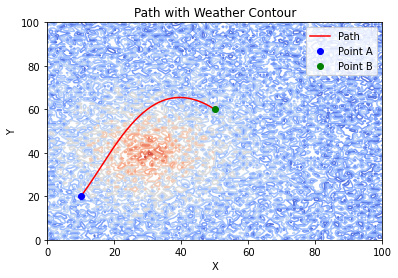

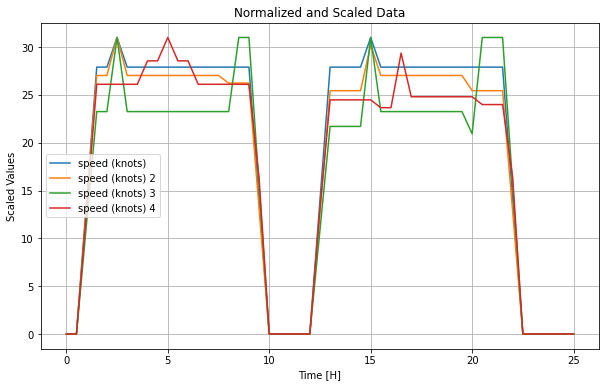

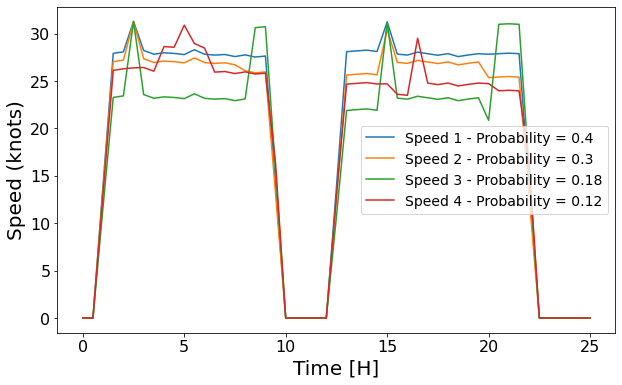

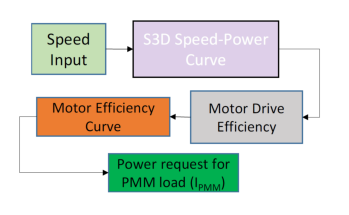

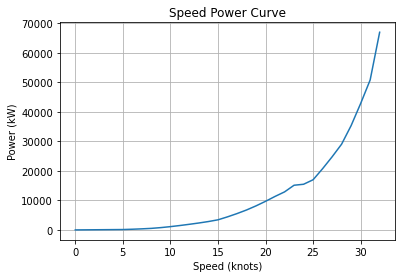

Predicted power at 26 knots: 20755.0 kW


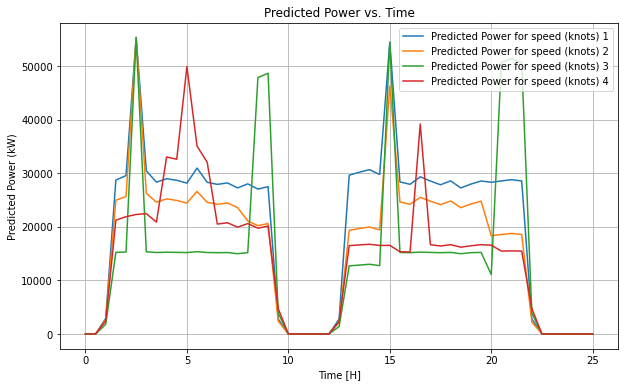

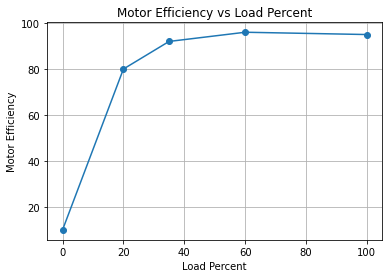

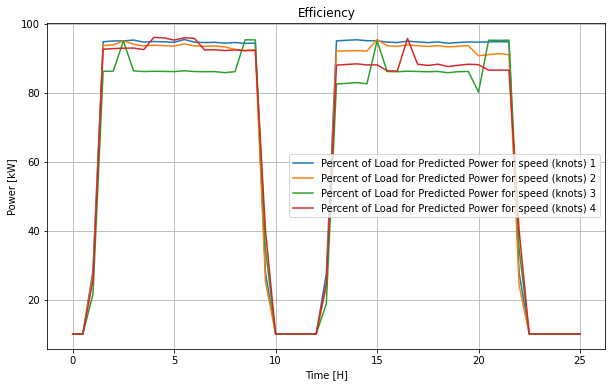

In [2]:
%run "Sizing Voyaging.ipynb"
# table_power

# Two stage stochastic model for energy management: 

$disc\_t$ = an array that captures total discrete times. <br>
$total\_scenario$ = total number of scenarios. <br>
$x\_cap\_b$ = first stage decision variable that represents the total battery capacity needed. <br>
$x\_cap\_s$ = first stage decision variable that represents the total SMR capacity needed. <br>

$x\_b[t, s]$ = Second stage continuous decision variable that represents the amount of battery capacity used to satisfy the total power at time t and scenario s. <br>
$x\_s[t, s]$ = Second stage continuous decision variable that represents the amount of SMR capacity used to satisfy the total power at time $t \in disc\_t$ and scenario $s \in total\_scenario$. <br>

The following are the known parameters: 
$c\_b, c\_s, m\_b, m\_s. $ 

(please feel free to tweak those parameters above!)

Mathematical model:


\begin{align}
 \text{minimize }\ & x\_cap\_b + x\_cap\_s + \sum_{s \in total\_scenario }\ \sum_{t \in disc\_t} c_b \ x_b[t, s] +c_s \ x_s[t, s]\\
 \text{subject to } \ & x_b[t, s] \leq x\_cap\_b && \text{ for all } t \in disc\_t, s \in total\_scenario\\
& x_s[t, s] \leq x\_cap\_s && \text{ for all } t \in disc\_t, s \in total\_scenario\\
& m_b \ x_b[t, s] + m_s \ x_s[t, s] \geq table\_power[t, s] && \text{ for all } t \in disc\_t, s \in total\_scenario\\
&  x\_cap\_b, x\_cap\_s \geq 0, \\ 
& x_b[t, s], x_s[t, s] \geq 0 && \text{ for all } t \in disc\_t, s \in total\_scenario.
\end{align}


In [3]:
# problem parameters set up

T = table_power.index
[m, n] = np.shape(table_power)
total_scenario = n - 1
S = range(total_scenario)
N_bus = 12 # grid voltage in kV.

c_b = 50
c_s = 50

m_b = 1
m_s = 1

min_eff = 0.1 
max_eff = 1.0

#delta_T = 0.27
delta_T = 1

Q_min = 1
Q_max = 10

In [4]:
max_power = table_power.iloc[:, 1:].max().max()
max_power

21.6698627027027

In [5]:

N_bus = 12
# Define the actual mode and solve it using Gurobi.

mdl = Model('Voyage_Sizing')

# Define decision variables for each scenario
x_cap_b = mdl.addVar(vtype = GRB.CONTINUOUS,lb=0, name = "x_cap_b")  # First stage decision variable representing the capacity of battery resource
x_cap_s = mdl.addVar(vtype = GRB.CONTINUOUS, name = "x_cap_s")  # First stage decision variable representing the capacity of SMR resource
x_b = mdl.addVars(T, S, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="x_b")
x_s = mdl.addVars(T, S, vtype = GRB.CONTINUOUS, name = "x_s") # Second stage decision var. representing the total amount of SMR
soc = mdl.addVars(T[1:], S, vtype = GRB.CONTINUOUS, name = "soc") # auxiliary variable (second stage)

imbalance1 = mdl.addVars(T, S, N_bus + 1, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="imbalance1")
v_p = mdl.addVars(T, S, N_bus+1, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="v_p")
loads_connected = mdl.addVars(T, S, N_bus + 1, vtype=GRB.CONTINUOUS, name="loads_connected")
generators_connected = mdl.addVars(T, S, N_bus + 1, vtype=GRB.CONTINUOUS, name="generators_connected")
batteries_connected = mdl.addVars(T, S, N_bus + 1, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY,
                                               name="batteries_connected")


Q = mdl.addVars(T, S, vtype = GRB.CONTINUOUS, name = "soc") # auxiliary variable (second stage)

mdl.modelSense = GRB.MINIMIZE




# Objective function

mdl.setObjective(0.5 * x_cap_b + x_cap_s + 
                 quicksum((x_b[t, s] + x_s[t, s] - table_power[f'Predicted Power for Route {s + 1}'].values[t]) 
                          for t in T for s in S))


# mdl.setObjective(0.5*x_cap_b + x_cap_s + c_b * quicksum(x_b[t, s] for t in T for s in S) +
#                  c_s * quicksum(x_s[t, s] for t in T for s in S)) 

routes = [f'Route {s + 1}' for s in S]

#########################################33
max_power = table_power.iloc[:, 1:].max().max()

mdl.addConstr(x_cap_b + x_cap_s >= 0.95 * max_power) # first stage constraint

mdl.addConstr(x_cap_b <= 4, "Cap_b_Limit")

buses_connected = [(1, 2), (1, 3), (1, 9), (2, 4), (2, 9), (3, 5), (3, 10),
                    (4, 6), (4, 10), (5, 7), (5, 11), (6, 8), (6, 11),
                    (7, 8), (7, 12), (8, 12)]

# Define line data
Y = np.zeros((N_bus, N_bus))
Y_dict = {}
for i in range(1, N_bus + 1):
    inner_dict = {}
    for j in range(1, N_bus + 1):
        inner_dict[j] = Y[i - 1, j - 1]
    Y_dict[i] = inner_dict
    
for i, j in buses_connected:
    Y_dict[i][j] = 1
    Y_dict[j][i] = 1



# below are all second stage constraints (which includes all the scenarios):
for s in S:
    for t in T:       
        # General constraints for x_s[t, s]
        mdl.addConstr(x_s[t, s] <= x_cap_s)
        mdl.addConstr(x_s[t, s] >= 0.74 * x_cap_s)
        
        
        mdl.addConstr(x_b[t, s] <= 1*x_cap_b) 
        mdl.addConstr(x_b[t, s] >= -1*x_cap_b) 

        # Power constraints for each scenario 
        route = routes[s]
        mdl.addConstr(m_b * x_b[t, s] + m_s * x_s[t, s] >=
                      table_power[f'Predicted Power for {route}'].values[t])
        
        # ramp rate constraints
        mdl.addConstrs(x_s[t, s] - x_s[t + 1, s] <= 0.15 * x_cap_s for t in T[:-1]) 
        mdl.addConstrs(x_s[t + 1, s] - x_s[t, s] <= 0.15 * x_cap_s for t in T[:-1])      
    
        # SOC calculation first and then bounds on SOC later
        soc[0, s]=0.3
        mdl.addConstrs(soc[t, s] * x_cap_b == soc[t - 1, s] * x_cap_b - x_b[t, s] * delta_T for t in T[1:]) 
    
        for t1 in T[1:]:
            mdl.addConstr(soc[t1, s] >= min_eff) 
            mdl.addConstr(soc[t1, s] <= 0.95*max_eff) 
    
        # ramp rate for soc 
        mdl.addConstrs(soc[t, s] - soc[t + 1, s] <= 0.50 for t in T[1:-1])
        mdl.addConstrs(soc[t + 1, s] - soc[t, s] <= 0.50 for t in T[1:-1])
        
        
        
        P_load = {(t, s, 5): table_power[f'Predicted Power for {route}'].values[t] / 2,
                  (t, s, 6): table_power[f'Predicted Power for {route}'].values[t] / 2,
                  (t, s, 9): 0.5, (t, s, 10): 0.5, (t, s, 11): 0.5,(t, s, 12): 0.5,
                   **{(t, s, p): 0 for p in range(1, N_bus + 1) if p not in [5, 6, 9, 10, 11, 12]}}
               
        P_battery = {(t, s, 7): x_b[t, s] / 2,
                         (t, s, 4): x_b[t, s] / 2,
                        **{(t, s, p): 0 for p in range(1, N_bus + 1) if p not in [4, 7]}}

        P_generator = {(t, s, 3): x_s[t, s] / 2,
                           (t, s, 8): x_s[t, s] / 2,
                           **{(t, s, p): 0 for p in range(1, N_bus + 1) if p not in [3, 8]}}

            
        for p in range(1, N_bus + 1):
            v_p[t, s, 0]=1
            imbalance1[t, s, 0]=1
            
            mdl.addConstr(loads_connected[(t, s, p)] == P_load.get((t, s, p), 0))

            mdl.addConstr(generators_connected[(t, s, p)] == P_generator[(t, s, p)])
            mdl.addConstr(batteries_connected[(t, s, p)] == P_battery[(t, s, p)])
            
            mdl.addConstr(imbalance1[(t, s, p)] == generators_connected[(t, s, p)] + batteries_connected[(t, s, p)]
                                       + loads_connected[(t, s, p)])
            
            mdl.addConstr(imbalance1[(t, s, p)] + sum(Y_dict[p][q] * 100*(v_p[t, s, p] - v_p[t, s, q]) for q in range(1, N_bus + 1) if p != q)
                         <= 5)
            
            # Adding the new constraints for v_p[t, s, p]
            mdl.addConstr(v_p[t, s, p] >= 0.95, name=f'v_p_lower_bound_{t}_{s}_{p}')
            mdl.addConstr(v_p[t, s, p] <= 1.05, name=f'v_p_upper_bound_{t}_{s}_{p}')
 

# solve the model now: 
mdl.params.NonConvex = 2

#mdl.Params.LogToConsole = 0 # to hide all the output log. Make it 1 to show the log.
mdl.optimize()
# loads_connected=mdl.getVarByName('loads_connected')

# Print first stage variables
print()
print("First Stage Variables:")
print(f"x_cap_b: {x_cap_b.x}")
print(f"x_cap_s: {x_cap_s.x}")
print()

# Print second stage variables
for s in S:
    print(f"Scenario {s + 1}:")
    print("Second Stage Variables:")
    for t in T[1:]:
        print(f"x_b[{t}, {s}]: {x_b[t, s].x}")
        print(f"x_s[{t}, {s}]: {x_s[t, s].x}")
        print(soc[t, s].x)
        for p in range(1, N_bus + 1):
            print(loads_connected[t, s, p])
        
    print()

Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-21
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Xeon(R) CPU E5-2603 v3 @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1537922 rows, 132466 columns and 3075843 nonzeros
Model fingerprint: 0xe44fe3cc
Model has 228480 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-01, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [3e-01, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+01]
Presolve removed 1495895 rows and 99872 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 595391 rows and 103680 columns (presolve time = 5s) ...
Presolve removed 1498044 rows and 103681 columns
Presolve time: 9.43s
Presolved: 49446 rows, 30689 columns,

<gurobi.Var loads_connected[82,0,7] (value 0.0)>
<gurobi.Var loads_connected[82,0,8] (value 0.0)>
<gurobi.Var loads_connected[82,0,9] (value 0.5)>
<gurobi.Var loads_connected[82,0,10] (value 0.5)>
<gurobi.Var loads_connected[82,0,11] (value 0.5)>
<gurobi.Var loads_connected[82,0,12] (value 0.5)>
x_b[83, 0]: 0.0
x_s[83, 0]: 16.291383351588152
0.1
<gurobi.Var loads_connected[83,0,1] (value 0.0)>
<gurobi.Var loads_connected[83,0,2] (value 0.0)>
<gurobi.Var loads_connected[83,0,3] (value 0.0)>
<gurobi.Var loads_connected[83,0,4] (value 0.0)>
<gurobi.Var loads_connected[83,0,5] (value 8.145691675794076)>
<gurobi.Var loads_connected[83,0,6] (value 8.145691675794076)>
<gurobi.Var loads_connected[83,0,7] (value 0.0)>
<gurobi.Var loads_connected[83,0,8] (value 0.0)>
<gurobi.Var loads_connected[83,0,9] (value 0.5)>
<gurobi.Var loads_connected[83,0,10] (value 0.5)>
<gurobi.Var loads_connected[83,0,11] (value 0.5)>
<gurobi.Var loads_connected[83,0,12] (value 0.5)>
x_b[84, 0]: 0.0
x_s[84, 0]: 16.29

x_s[34, 1]: 15.849993269220548
0.4500000000000003
<gurobi.Var loads_connected[34,1,1] (value 0.0)>
<gurobi.Var loads_connected[34,1,2] (value 0.0)>
<gurobi.Var loads_connected[34,1,3] (value 0.0)>
<gurobi.Var loads_connected[34,1,4] (value 0.0)>
<gurobi.Var loads_connected[34,1,5] (value 6.211773435722407)>
<gurobi.Var loads_connected[34,1,6] (value 6.211773435722407)>
<gurobi.Var loads_connected[34,1,7] (value 0.0)>
<gurobi.Var loads_connected[34,1,8] (value 0.0)>
<gurobi.Var loads_connected[34,1,9] (value 0.5)>
<gurobi.Var loads_connected[34,1,10] (value 0.5)>
<gurobi.Var loads_connected[34,1,11] (value 0.5)>
<gurobi.Var loads_connected[34,1,12] (value 0.5)>
x_b[35, 1]: -1.9999999999999996
x_s[35, 1]: 15.849993269220548
0.9500000000000003
<gurobi.Var loads_connected[35,1,1] (value 0.0)>
<gurobi.Var loads_connected[35,1,2] (value 0.0)>
<gurobi.Var loads_connected[35,1,3] (value 0.0)>
<gurobi.Var loads_connected[35,1,4] (value 0.0)>
<gurobi.Var loads_connected[35,1,5] (value 6.36966159

<gurobi.Var loads_connected[67,1,3] (value 0.0)>
<gurobi.Var loads_connected[67,1,4] (value 0.0)>
<gurobi.Var loads_connected[67,1,5] (value 9.688838805970091)>
<gurobi.Var loads_connected[67,1,6] (value 9.688838805970091)>
<gurobi.Var loads_connected[67,1,7] (value 0.0)>
<gurobi.Var loads_connected[67,1,8] (value 0.0)>
<gurobi.Var loads_connected[67,1,9] (value 0.5)>
<gurobi.Var loads_connected[67,1,10] (value 0.5)>
<gurobi.Var loads_connected[67,1,11] (value 0.5)>
<gurobi.Var loads_connected[67,1,12] (value 0.5)>
x_b[68, 1]: 0.0
x_s[68, 1]: 19.37418260869559
0.1
<gurobi.Var loads_connected[68,1,1] (value 0.0)>
<gurobi.Var loads_connected[68,1,2] (value 0.0)>
<gurobi.Var loads_connected[68,1,3] (value 0.0)>
<gurobi.Var loads_connected[68,1,4] (value 0.0)>
<gurobi.Var loads_connected[68,1,5] (value 9.687091304347796)>
<gurobi.Var loads_connected[68,1,6] (value 9.687091304347796)>
<gurobi.Var loads_connected[68,1,7] (value 0.0)>
<gurobi.Var loads_connected[68,1,8] (value 0.0)>
<gurobi.V

<gurobi.Var loads_connected[100,1,8] (value 0.0)>
<gurobi.Var loads_connected[100,1,9] (value 0.5)>
<gurobi.Var loads_connected[100,1,10] (value 0.5)>
<gurobi.Var loads_connected[100,1,11] (value 0.5)>
<gurobi.Var loads_connected[100,1,12] (value 0.5)>
x_b[101, 1]: 0.0
x_s[101, 1]: 19.386157359813012
0.1
<gurobi.Var loads_connected[101,1,1] (value 0.0)>
<gurobi.Var loads_connected[101,1,2] (value 0.0)>
<gurobi.Var loads_connected[101,1,3] (value 0.0)>
<gurobi.Var loads_connected[101,1,4] (value 0.0)>
<gurobi.Var loads_connected[101,1,5] (value 9.693078679906506)>
<gurobi.Var loads_connected[101,1,6] (value 9.693078679906506)>
<gurobi.Var loads_connected[101,1,7] (value 0.0)>
<gurobi.Var loads_connected[101,1,8] (value 0.0)>
<gurobi.Var loads_connected[101,1,9] (value 0.5)>
<gurobi.Var loads_connected[101,1,10] (value 0.5)>
<gurobi.Var loads_connected[101,1,11] (value 0.5)>
<gurobi.Var loads_connected[101,1,12] (value 0.5)>
x_b[102, 1]: 0.0
x_s[102, 1]: 19.39012427807481
0.1
<gurobi.Var

<gurobi.Var loads_connected[14,2,9] (value 0.5)>
<gurobi.Var loads_connected[14,2,10] (value 0.5)>
<gurobi.Var loads_connected[14,2,11] (value 0.5)>
<gurobi.Var loads_connected[14,2,12] (value 0.5)>
x_b[15, 2]: 0.0
x_s[15, 2]: 15.849993269220548
0.9500000000000002
<gurobi.Var loads_connected[15,2,1] (value 0.0)>
<gurobi.Var loads_connected[15,2,2] (value 0.0)>
<gurobi.Var loads_connected[15,2,3] (value 0.0)>
<gurobi.Var loads_connected[15,2,4] (value 0.0)>
<gurobi.Var loads_connected[15,2,5] (value 6.21359732234809)>
<gurobi.Var loads_connected[15,2,6] (value 6.21359732234809)>
<gurobi.Var loads_connected[15,2,7] (value 0.0)>
<gurobi.Var loads_connected[15,2,8] (value 0.0)>
<gurobi.Var loads_connected[15,2,9] (value 0.5)>
<gurobi.Var loads_connected[15,2,10] (value 0.5)>
<gurobi.Var loads_connected[15,2,11] (value 0.5)>
<gurobi.Var loads_connected[15,2,12] (value 0.5)>
x_b[16, 2]: 0.18926679536502888
x_s[16, 2]: 15.849993269220548
0.902683301158743
<gurobi.Var loads_connected[16,2,1] (

<gurobi.Var loads_connected[66,2,8] (value 0.0)>
<gurobi.Var loads_connected[66,2,9] (value 0.5)>
<gurobi.Var loads_connected[66,2,10] (value 0.5)>
<gurobi.Var loads_connected[66,2,11] (value 0.5)>
<gurobi.Var loads_connected[66,2,12] (value 0.5)>
x_b[67, 2]: 0.7864027401691054
x_s[67, 2]: 15.849993269220548
0.5241787077540767
<gurobi.Var loads_connected[67,2,1] (value 0.0)>
<gurobi.Var loads_connected[67,2,2] (value 0.0)>
<gurobi.Var loads_connected[67,2,3] (value 0.0)>
<gurobi.Var loads_connected[67,2,4] (value 0.0)>
<gurobi.Var loads_connected[67,2,5] (value 8.318198004694827)>
<gurobi.Var loads_connected[67,2,6] (value 8.318198004694827)>
<gurobi.Var loads_connected[67,2,7] (value 0.0)>
<gurobi.Var loads_connected[67,2,8] (value 0.0)>
<gurobi.Var loads_connected[67,2,9] (value 0.5)>
<gurobi.Var loads_connected[67,2,10] (value 0.5)>
<gurobi.Var loads_connected[67,2,11] (value 0.5)>
<gurobi.Var loads_connected[67,2,12] (value 0.5)>
x_b[68, 2]: 1.126970403836971
x_s[68, 2]: 15.8499932

<gurobi.Var loads_connected[81,2,3] (value 0.0)>
<gurobi.Var loads_connected[81,2,4] (value 0.0)>
<gurobi.Var loads_connected[81,2,5] (value 8.784513951011707)>
<gurobi.Var loads_connected[81,2,6] (value 8.784513951011707)>
<gurobi.Var loads_connected[81,2,7] (value 0.0)>
<gurobi.Var loads_connected[81,2,8] (value 0.0)>
<gurobi.Var loads_connected[81,2,9] (value 0.5)>
<gurobi.Var loads_connected[81,2,10] (value 0.5)>
<gurobi.Var loads_connected[81,2,11] (value 0.5)>
<gurobi.Var loads_connected[81,2,12] (value 0.5)>
x_b[82, 2]: 0.0
x_s[82, 2]: 18.210461145194266
0.1
<gurobi.Var loads_connected[82,2,1] (value 0.0)>
<gurobi.Var loads_connected[82,2,2] (value 0.0)>
<gurobi.Var loads_connected[82,2,3] (value 0.0)>
<gurobi.Var loads_connected[82,2,4] (value 0.0)>
<gurobi.Var loads_connected[82,2,5] (value 9.105230572597133)>
<gurobi.Var loads_connected[82,2,6] (value 9.105230572597133)>
<gurobi.Var loads_connected[82,2,7] (value 0.0)>
<gurobi.Var loads_connected[82,2,8] (value 0.0)>
<gurobi.

<gurobi.Var loads_connected[96,2,7] (value 0.0)>
<gurobi.Var loads_connected[96,2,8] (value 0.0)>
<gurobi.Var loads_connected[96,2,9] (value 0.5)>
<gurobi.Var loads_connected[96,2,10] (value 0.5)>
<gurobi.Var loads_connected[96,2,11] (value 0.5)>
<gurobi.Var loads_connected[96,2,12] (value 0.5)>
x_b[97, 2]: 0.0
x_s[97, 2]: 15.849993269220548
0.1
<gurobi.Var loads_connected[97,2,1] (value 0.0)>
<gurobi.Var loads_connected[97,2,2] (value 0.0)>
<gurobi.Var loads_connected[97,2,3] (value 0.0)>
<gurobi.Var loads_connected[97,2,4] (value 0.0)>
<gurobi.Var loads_connected[97,2,5] (value 7.599219822812839)>
<gurobi.Var loads_connected[97,2,6] (value 7.599219822812839)>
<gurobi.Var loads_connected[97,2,7] (value 0.0)>
<gurobi.Var loads_connected[97,2,8] (value 0.0)>
<gurobi.Var loads_connected[97,2,9] (value 0.5)>
<gurobi.Var loads_connected[97,2,10] (value 0.5)>
<gurobi.Var loads_connected[97,2,11] (value 0.5)>
<gurobi.Var loads_connected[97,2,12] (value 0.5)>
x_b[98, 2]: 0.0
x_s[98, 2]: 15.84

<gurobi.Var loads_connected[28,3,10] (value 0.5)>
<gurobi.Var loads_connected[28,3,11] (value 0.5)>
<gurobi.Var loads_connected[28,3,12] (value 0.5)>
x_b[29, 3]: -2.0
x_s[29, 3]: 15.849993269220548
0.6
<gurobi.Var loads_connected[29,3,1] (value 0.0)>
<gurobi.Var loads_connected[29,3,2] (value 0.0)>
<gurobi.Var loads_connected[29,3,3] (value 0.0)>
<gurobi.Var loads_connected[29,3,4] (value 0.0)>
<gurobi.Var loads_connected[29,3,5] (value 5.333979097909786)>
<gurobi.Var loads_connected[29,3,6] (value 5.333979097909786)>
<gurobi.Var loads_connected[29,3,7] (value 0.0)>
<gurobi.Var loads_connected[29,3,8] (value 0.0)>
<gurobi.Var loads_connected[29,3,9] (value 0.5)>
<gurobi.Var loads_connected[29,3,10] (value 0.5)>
<gurobi.Var loads_connected[29,3,11] (value 0.5)>
<gurobi.Var loads_connected[29,3,12] (value 0.5)>
x_b[30, 3]: -1.4000000000000008
x_s[30, 3]: 15.849993269220548
0.9500000000000003
<gurobi.Var loads_connected[30,3,1] (value 0.0)>
<gurobi.Var loads_connected[30,3,2] (value 0.0)>

<gurobi.Var loads_connected[42,3,1] (value 0.0)>
<gurobi.Var loads_connected[42,3,2] (value 0.0)>
<gurobi.Var loads_connected[42,3,3] (value 0.0)>
<gurobi.Var loads_connected[42,3,4] (value 0.0)>
<gurobi.Var loads_connected[42,3,5] (value 5.8379522246940985)>
<gurobi.Var loads_connected[42,3,6] (value 5.8379522246940985)>
<gurobi.Var loads_connected[42,3,7] (value 0.0)>
<gurobi.Var loads_connected[42,3,8] (value 0.0)>
<gurobi.Var loads_connected[42,3,9] (value 0.5)>
<gurobi.Var loads_connected[42,3,10] (value 0.5)>
<gurobi.Var loads_connected[42,3,11] (value 0.5)>
<gurobi.Var loads_connected[42,3,12] (value 0.5)>
x_b[43, 3]: 1.4000000000000012
x_s[43, 3]: 15.849993269220548
0.1
<gurobi.Var loads_connected[43,3,1] (value 0.0)>
<gurobi.Var loads_connected[43,3,2] (value 0.0)>
<gurobi.Var loads_connected[43,3,3] (value 0.0)>
<gurobi.Var loads_connected[43,3,4] (value 0.0)>
<gurobi.Var loads_connected[43,3,5] (value 5.998541779141102)>
<gurobi.Var loads_connected[43,3,6] (value 5.998541779

x_s[62, 3]: 15.849993269220548
0.1568980186222272
<gurobi.Var loads_connected[62,3,1] (value 0.0)>
<gurobi.Var loads_connected[62,3,2] (value 0.0)>
<gurobi.Var loads_connected[62,3,3] (value 0.0)>
<gurobi.Var loads_connected[62,3,4] (value 0.0)>
<gurobi.Var loads_connected[62,3,5] (value 6.996261163895482)>
<gurobi.Var loads_connected[62,3,6] (value 6.996261163895482)>
<gurobi.Var loads_connected[62,3,7] (value 0.0)>
<gurobi.Var loads_connected[62,3,8] (value 0.0)>
<gurobi.Var loads_connected[62,3,9] (value 0.5)>
<gurobi.Var loads_connected[62,3,10] (value 0.5)>
<gurobi.Var loads_connected[62,3,11] (value 0.5)>
<gurobi.Var loads_connected[62,3,12] (value 0.5)>
x_b[63, 3]: -1.7724079255110912
x_s[63, 3]: 15.849993269220548
0.6
<gurobi.Var loads_connected[63,3,1] (value 0.0)>
<gurobi.Var loads_connected[63,3,2] (value 0.0)>
<gurobi.Var loads_connected[63,3,3] (value 0.0)>
<gurobi.Var loads_connected[63,3,4] (value 0.0)>
<gurobi.Var loads_connected[63,3,5] (value 7.038792671854728)>
<guro

<gurobi.Var loads_connected[107,3,8] (value 0.0)>
<gurobi.Var loads_connected[107,3,9] (value 0.5)>
<gurobi.Var loads_connected[107,3,10] (value 0.5)>
<gurobi.Var loads_connected[107,3,11] (value 0.5)>
<gurobi.Var loads_connected[107,3,12] (value 0.5)>
x_b[108, 3]: 1.4000000000000004
x_s[108, 3]: 15.849993269220548
0.6
<gurobi.Var loads_connected[108,3,1] (value 0.0)>
<gurobi.Var loads_connected[108,3,2] (value 0.0)>
<gurobi.Var loads_connected[108,3,3] (value 0.0)>
<gurobi.Var loads_connected[108,3,4] (value 0.0)>
<gurobi.Var loads_connected[108,3,5] (value 4.949957334963323)>
<gurobi.Var loads_connected[108,3,6] (value 4.949957334963323)>
<gurobi.Var loads_connected[108,3,7] (value 0.0)>
<gurobi.Var loads_connected[108,3,8] (value 0.0)>
<gurobi.Var loads_connected[108,3,9] (value 0.5)>
<gurobi.Var loads_connected[108,3,10] (value 0.5)>
<gurobi.Var loads_connected[108,3,11] (value 0.5)>
<gurobi.Var loads_connected[108,3,12] (value 0.5)>
x_b[109, 3]: 2.0
x_s[109, 3]: 15.849993269220548

<gurobi.Var loads_connected[9,4,5] (value 5.367923141891888)>
<gurobi.Var loads_connected[9,4,6] (value 5.367923141891888)>
<gurobi.Var loads_connected[9,4,7] (value 0.0)>
<gurobi.Var loads_connected[9,4,8] (value 0.0)>
<gurobi.Var loads_connected[9,4,9] (value 0.5)>
<gurobi.Var loads_connected[9,4,10] (value 0.5)>
<gurobi.Var loads_connected[9,4,11] (value 0.5)>
<gurobi.Var loads_connected[9,4,12] (value 0.5)>
x_b[10, 4]: 0.0
x_s[10, 4]: 15.849993269220548
0.9500000000000003
<gurobi.Var loads_connected[10,4,1] (value 0.0)>
<gurobi.Var loads_connected[10,4,2] (value 0.0)>
<gurobi.Var loads_connected[10,4,3] (value 0.0)>
<gurobi.Var loads_connected[10,4,4] (value 0.0)>
<gurobi.Var loads_connected[10,4,5] (value 5.42006908665105)>
<gurobi.Var loads_connected[10,4,6] (value 5.42006908665105)>
<gurobi.Var loads_connected[10,4,7] (value 0.0)>
<gurobi.Var loads_connected[10,4,8] (value 0.0)>
<gurobi.Var loads_connected[10,4,9] (value 0.5)>
<gurobi.Var loads_connected[10,4,10] (value 0.5)>
<g

x_s[76, 4]: 15.849993269220548
0.9500000000000003
<gurobi.Var loads_connected[76,4,1] (value 0.0)>
<gurobi.Var loads_connected[76,4,2] (value 0.0)>
<gurobi.Var loads_connected[76,4,3] (value 0.0)>
<gurobi.Var loads_connected[76,4,4] (value 0.0)>
<gurobi.Var loads_connected[76,4,5] (value 6.194193960149438)>
<gurobi.Var loads_connected[76,4,6] (value 6.194193960149438)>
<gurobi.Var loads_connected[76,4,7] (value 0.0)>
<gurobi.Var loads_connected[76,4,8] (value 0.0)>
<gurobi.Var loads_connected[76,4,9] (value 0.5)>
<gurobi.Var loads_connected[76,4,10] (value 0.5)>
<gurobi.Var loads_connected[76,4,11] (value 0.5)>
<gurobi.Var loads_connected[76,4,12] (value 0.5)>
x_b[77, 4]: 0.0
x_s[77, 4]: 15.849993269220548
0.9500000000000003
<gurobi.Var loads_connected[77,4,1] (value 0.0)>
<gurobi.Var loads_connected[77,4,2] (value 0.0)>
<gurobi.Var loads_connected[77,4,3] (value 0.0)>
<gurobi.Var loads_connected[77,4,4] (value 0.0)>
<gurobi.Var loads_connected[77,4,5] (value 6.43304023668639)>
<gurobi

<gurobi.Var loads_connected[109,4,3] (value 0.0)>
<gurobi.Var loads_connected[109,4,4] (value 0.0)>
<gurobi.Var loads_connected[109,4,5] (value 7.6508255148741)>
<gurobi.Var loads_connected[109,4,6] (value 7.6508255148741)>
<gurobi.Var loads_connected[109,4,7] (value 0.0)>
<gurobi.Var loads_connected[109,4,8] (value 0.0)>
<gurobi.Var loads_connected[109,4,9] (value 0.5)>
<gurobi.Var loads_connected[109,4,10] (value 0.5)>
<gurobi.Var loads_connected[109,4,11] (value 0.5)>
<gurobi.Var loads_connected[109,4,12] (value 0.5)>
x_b[110, 4]: 0.0
x_s[110, 4]: 15.849993269220548
0.1
<gurobi.Var loads_connected[110,4,1] (value 0.0)>
<gurobi.Var loads_connected[110,4,2] (value 0.0)>
<gurobi.Var loads_connected[110,4,3] (value 0.0)>
<gurobi.Var loads_connected[110,4,4] (value 0.0)>
<gurobi.Var loads_connected[110,4,5] (value 7.554986601705226)>
<gurobi.Var loads_connected[110,4,6] (value 7.554986601705226)>
<gurobi.Var loads_connected[110,4,7] (value 0.0)>
<gurobi.Var loads_connected[110,4,8] (valu

<gurobi.Var loads_connected[42,5,4] (value 0.0)>
<gurobi.Var loads_connected[42,5,5] (value 5.837121040723974)>
<gurobi.Var loads_connected[42,5,6] (value 5.837121040723974)>
<gurobi.Var loads_connected[42,5,7] (value 0.0)>
<gurobi.Var loads_connected[42,5,8] (value 0.0)>
<gurobi.Var loads_connected[42,5,9] (value 0.5)>
<gurobi.Var loads_connected[42,5,10] (value 0.5)>
<gurobi.Var loads_connected[42,5,11] (value 0.5)>
<gurobi.Var loads_connected[42,5,12] (value 0.5)>
x_b[43, 5]: 0.0
x_s[43, 5]: 15.849993269220548
0.9500000000000002
<gurobi.Var loads_connected[43,5,1] (value 0.0)>
<gurobi.Var loads_connected[43,5,2] (value 0.0)>
<gurobi.Var loads_connected[43,5,3] (value 0.0)>
<gurobi.Var loads_connected[43,5,4] (value 0.0)>
<gurobi.Var loads_connected[43,5,5] (value 5.8655614583333335)>
<gurobi.Var loads_connected[43,5,6] (value 5.8655614583333335)>
<gurobi.Var loads_connected[43,5,7] (value 0.0)>
<gurobi.Var loads_connected[43,5,8] (value 0.0)>
<gurobi.Var loads_connected[43,5,9] (val

<gurobi.Var loads_connected[69,5,7] (value 0.0)>
<gurobi.Var loads_connected[69,5,8] (value 0.0)>
<gurobi.Var loads_connected[69,5,9] (value 0.5)>
<gurobi.Var loads_connected[69,5,10] (value 0.5)>
<gurobi.Var loads_connected[69,5,11] (value 0.5)>
<gurobi.Var loads_connected[69,5,12] (value 0.5)>
x_b[70, 5]: -2.0
x_s[70, 5]: 15.849993269220548
0.9500000000000002
<gurobi.Var loads_connected[70,5,1] (value 0.0)>
<gurobi.Var loads_connected[70,5,2] (value 0.0)>
<gurobi.Var loads_connected[70,5,3] (value 0.0)>
<gurobi.Var loads_connected[70,5,4] (value 0.0)>
<gurobi.Var loads_connected[70,5,5] (value 0.46366576019777433)>
<gurobi.Var loads_connected[70,5,6] (value 0.46366576019777433)>
<gurobi.Var loads_connected[70,5,7] (value 0.0)>
<gurobi.Var loads_connected[70,5,8] (value 0.0)>
<gurobi.Var loads_connected[70,5,9] (value 0.5)>
<gurobi.Var loads_connected[70,5,10] (value 0.5)>
<gurobi.Var loads_connected[70,5,11] (value 0.5)>
<gurobi.Var loads_connected[70,5,12] (value 0.5)>
x_b[71, 5]: 2

<gurobi.Var loads_connected[108,5,9] (value 0.5)>
<gurobi.Var loads_connected[108,5,10] (value 0.5)>
<gurobi.Var loads_connected[108,5,11] (value 0.5)>
<gurobi.Var loads_connected[108,5,12] (value 0.5)>
x_b[109, 5]: 1.4000000000000004
x_s[109, 5]: 15.849993269220548
0.1
<gurobi.Var loads_connected[109,5,1] (value 0.0)>
<gurobi.Var loads_connected[109,5,2] (value 0.0)>
<gurobi.Var loads_connected[109,5,3] (value 0.0)>
<gurobi.Var loads_connected[109,5,4] (value 0.0)>
<gurobi.Var loads_connected[109,5,5] (value 5.85025469678953)>
<gurobi.Var loads_connected[109,5,6] (value 5.85025469678953)>
<gurobi.Var loads_connected[109,5,7] (value 0.0)>
<gurobi.Var loads_connected[109,5,8] (value 0.0)>
<gurobi.Var loads_connected[109,5,9] (value 0.5)>
<gurobi.Var loads_connected[109,5,10] (value 0.5)>
<gurobi.Var loads_connected[109,5,11] (value 0.5)>
<gurobi.Var loads_connected[109,5,12] (value 0.5)>
x_b[110, 5]: 0.0
x_s[110, 5]: 15.849993269220548
0.1
<gurobi.Var loads_connected[110,5,1] (value 0.0

<gurobi.Var loads_connected[4,6,1] (value 0.0)>
<gurobi.Var loads_connected[4,6,2] (value 0.0)>
<gurobi.Var loads_connected[4,6,3] (value 0.0)>
<gurobi.Var loads_connected[4,6,4] (value 0.0)>
<gurobi.Var loads_connected[4,6,5] (value 7.69996450428396)>
<gurobi.Var loads_connected[4,6,6] (value 7.69996450428396)>
<gurobi.Var loads_connected[4,6,7] (value 0.0)>
<gurobi.Var loads_connected[4,6,8] (value 0.0)>
<gurobi.Var loads_connected[4,6,9] (value 0.5)>
<gurobi.Var loads_connected[4,6,10] (value 0.5)>
<gurobi.Var loads_connected[4,6,11] (value 0.5)>
<gurobi.Var loads_connected[4,6,12] (value 0.5)>
x_b[5, 6]: 0.0
x_s[5, 6]: 15.849993269220548
0.1
<gurobi.Var loads_connected[5,6,1] (value 0.0)>
<gurobi.Var loads_connected[5,6,2] (value 0.0)>
<gurobi.Var loads_connected[5,6,3] (value 0.0)>
<gurobi.Var loads_connected[5,6,4] (value 0.0)>
<gurobi.Var loads_connected[5,6,5] (value 7.24375434243176)>
<gurobi.Var loads_connected[5,6,6] (value 7.24375434243176)>
<gurobi.Var loads_connected[5,6,

<gurobi.Var loads_connected[19,6,12] (value 0.5)>
x_b[20, 6]: 0.0
x_s[20, 6]: 15.849993269220548
0.1
<gurobi.Var loads_connected[20,6,1] (value 0.0)>
<gurobi.Var loads_connected[20,6,2] (value 0.0)>
<gurobi.Var loads_connected[20,6,3] (value 0.0)>
<gurobi.Var loads_connected[20,6,4] (value 0.0)>
<gurobi.Var loads_connected[20,6,5] (value 6.61160224719101)>
<gurobi.Var loads_connected[20,6,6] (value 6.61160224719101)>
<gurobi.Var loads_connected[20,6,7] (value 0.0)>
<gurobi.Var loads_connected[20,6,8] (value 0.0)>
<gurobi.Var loads_connected[20,6,9] (value 0.5)>
<gurobi.Var loads_connected[20,6,10] (value 0.5)>
<gurobi.Var loads_connected[20,6,11] (value 0.5)>
<gurobi.Var loads_connected[20,6,12] (value 0.5)>
x_b[21, 6]: -1.4000000000000008
x_s[21, 6]: 15.849993269220548
0.4500000000000002
<gurobi.Var loads_connected[21,6,1] (value 0.0)>
<gurobi.Var loads_connected[21,6,2] (value 0.0)>
<gurobi.Var loads_connected[21,6,3] (value 0.0)>
<gurobi.Var loads_connected[21,6,4] (value 0.0)>
<gur

<gurobi.Var loads_connected[61,6,1] (value 0.0)>
<gurobi.Var loads_connected[61,6,2] (value 0.0)>
<gurobi.Var loads_connected[61,6,3] (value 0.0)>
<gurobi.Var loads_connected[61,6,4] (value 0.0)>
<gurobi.Var loads_connected[61,6,5] (value 5.8572673056443)>
<gurobi.Var loads_connected[61,6,6] (value 5.8572673056443)>
<gurobi.Var loads_connected[61,6,7] (value 0.0)>
<gurobi.Var loads_connected[61,6,8] (value 0.0)>
<gurobi.Var loads_connected[61,6,9] (value 0.5)>
<gurobi.Var loads_connected[61,6,10] (value 0.5)>
<gurobi.Var loads_connected[61,6,11] (value 0.5)>
<gurobi.Var loads_connected[61,6,12] (value 0.5)>
x_b[62, 6]: 0.0
x_s[62, 6]: 15.849993269220548
0.1
<gurobi.Var loads_connected[62,6,1] (value 0.0)>
<gurobi.Var loads_connected[62,6,2] (value 0.0)>
<gurobi.Var loads_connected[62,6,3] (value 0.0)>
<gurobi.Var loads_connected[62,6,4] (value 0.0)>
<gurobi.Var loads_connected[62,6,5] (value 5.82242793791574)>
<gurobi.Var loads_connected[62,6,6] (value 5.82242793791574)>
<gurobi.Var lo

<gurobi.Var loads_connected[76,6,11] (value 0.5)>
<gurobi.Var loads_connected[76,6,12] (value 0.5)>
x_b[77, 6]: 0.0
x_s[77, 6]: 15.849993269220548
0.9500000000000002
<gurobi.Var loads_connected[77,6,1] (value 0.0)>
<gurobi.Var loads_connected[77,6,2] (value 0.0)>
<gurobi.Var loads_connected[77,6,3] (value 0.0)>
<gurobi.Var loads_connected[77,6,4] (value 0.0)>
<gurobi.Var loads_connected[77,6,5] (value 6.93733254716981)>
<gurobi.Var loads_connected[77,6,6] (value 6.93733254716981)>
<gurobi.Var loads_connected[77,6,7] (value 0.0)>
<gurobi.Var loads_connected[77,6,8] (value 0.0)>
<gurobi.Var loads_connected[77,6,9] (value 0.5)>
<gurobi.Var loads_connected[77,6,10] (value 0.5)>
<gurobi.Var loads_connected[77,6,11] (value 0.5)>
<gurobi.Var loads_connected[77,6,12] (value 0.5)>
x_b[78, 6]: 0.0
x_s[78, 6]: 15.849993269220548
0.9500000000000002
<gurobi.Var loads_connected[78,6,1] (value 0.0)>
<gurobi.Var loads_connected[78,6,2] (value 0.0)>
<gurobi.Var loads_connected[78,6,3] (value 0.0)>
<gur

x_b[104, 6]: 0.0
x_s[104, 6]: 15.849993269220548
0.4500000000000002
<gurobi.Var loads_connected[104,6,1] (value 0.0)>
<gurobi.Var loads_connected[104,6,2] (value 0.0)>
<gurobi.Var loads_connected[104,6,3] (value 0.0)>
<gurobi.Var loads_connected[104,6,4] (value 0.0)>
<gurobi.Var loads_connected[104,6,5] (value 5.82415012106537)>
<gurobi.Var loads_connected[104,6,6] (value 5.82415012106537)>
<gurobi.Var loads_connected[104,6,7] (value 0.0)>
<gurobi.Var loads_connected[104,6,8] (value 0.0)>
<gurobi.Var loads_connected[104,6,9] (value 0.5)>
<gurobi.Var loads_connected[104,6,10] (value 0.5)>
<gurobi.Var loads_connected[104,6,11] (value 0.5)>
<gurobi.Var loads_connected[104,6,12] (value 0.5)>
x_b[105, 6]: -2.0
x_s[105, 6]: 15.849993269220548
0.9500000000000002
<gurobi.Var loads_connected[105,6,1] (value 0.0)>
<gurobi.Var loads_connected[105,6,2] (value 0.0)>
<gurobi.Var loads_connected[105,6,3] (value 0.0)>
<gurobi.Var loads_connected[105,6,4] (value 0.0)>
<gurobi.Var loads_connected[105,6,

<gurobi.Var loads_connected[21,7,10] (value 0.5)>
<gurobi.Var loads_connected[21,7,11] (value 0.5)>
<gurobi.Var loads_connected[21,7,12] (value 0.5)>
x_b[22, 7]: -2.0
x_s[22, 7]: 15.849993269220548
0.9500000000000002
<gurobi.Var loads_connected[22,7,1] (value 0.0)>
<gurobi.Var loads_connected[22,7,2] (value 0.0)>
<gurobi.Var loads_connected[22,7,3] (value 0.0)>
<gurobi.Var loads_connected[22,7,4] (value 0.0)>
<gurobi.Var loads_connected[22,7,5] (value 6.90105276381909)>
<gurobi.Var loads_connected[22,7,6] (value 6.90105276381909)>
<gurobi.Var loads_connected[22,7,7] (value 0.0)>
<gurobi.Var loads_connected[22,7,8] (value 0.0)>
<gurobi.Var loads_connected[22,7,9] (value 0.5)>
<gurobi.Var loads_connected[22,7,10] (value 0.5)>
<gurobi.Var loads_connected[22,7,11] (value 0.5)>
<gurobi.Var loads_connected[22,7,12] (value 0.5)>
x_b[23, 7]: 0.0
x_s[23, 7]: 15.849993269220548
0.9500000000000002
<gurobi.Var loads_connected[23,7,1] (value 0.0)>
<gurobi.Var loads_connected[23,7,2] (value 0.0)>
<g

<gurobi.Var loads_connected[43,7,3] (value 0.0)>
<gurobi.Var loads_connected[43,7,4] (value 0.0)>
<gurobi.Var loads_connected[43,7,5] (value 7.8200106635071)>
<gurobi.Var loads_connected[43,7,6] (value 7.8200106635071)>
<gurobi.Var loads_connected[43,7,7] (value 0.0)>
<gurobi.Var loads_connected[43,7,8] (value 0.0)>
<gurobi.Var loads_connected[43,7,9] (value 0.5)>
<gurobi.Var loads_connected[43,7,10] (value 0.5)>
<gurobi.Var loads_connected[43,7,11] (value 0.5)>
<gurobi.Var loads_connected[43,7,12] (value 0.5)>
x_b[44, 7]: 0.0
x_s[44, 7]: 15.849993269220548
0.1
<gurobi.Var loads_connected[44,7,1] (value 0.0)>
<gurobi.Var loads_connected[44,7,2] (value 0.0)>
<gurobi.Var loads_connected[44,7,3] (value 0.0)>
<gurobi.Var loads_connected[44,7,4] (value 0.0)>
<gurobi.Var loads_connected[44,7,5] (value 7.76647901234567)>
<gurobi.Var loads_connected[44,7,6] (value 7.76647901234567)>
<gurobi.Var loads_connected[44,7,7] (value 0.0)>
<gurobi.Var loads_connected[44,7,8] (value 0.0)>
<gurobi.Var lo

<gurobi.Var loads_connected[106,7,4] (value 0.0)>
<gurobi.Var loads_connected[106,7,5] (value 5.12971563483735)>
<gurobi.Var loads_connected[106,7,6] (value 5.12971563483735)>
<gurobi.Var loads_connected[106,7,7] (value 0.0)>
<gurobi.Var loads_connected[106,7,8] (value 0.0)>
<gurobi.Var loads_connected[106,7,9] (value 0.5)>
<gurobi.Var loads_connected[106,7,10] (value 0.5)>
<gurobi.Var loads_connected[106,7,11] (value 0.5)>
<gurobi.Var loads_connected[106,7,12] (value 0.5)>
x_b[107, 7]: -2.0
x_s[107, 7]: 15.849993269220548
0.6
<gurobi.Var loads_connected[107,7,1] (value 0.0)>
<gurobi.Var loads_connected[107,7,2] (value 0.0)>
<gurobi.Var loads_connected[107,7,3] (value 0.0)>
<gurobi.Var loads_connected[107,7,4] (value 0.0)>
<gurobi.Var loads_connected[107,7,5] (value 5.14706861642294)>
<gurobi.Var loads_connected[107,7,6] (value 5.14706861642294)>
<gurobi.Var loads_connected[107,7,7] (value 0.0)>
<gurobi.Var loads_connected[107,7,8] (value 0.0)>
<gurobi.Var loads_connected[107,7,9] (val

<gurobi.Var loads_connected[16,8,4] (value 0.0)>
<gurobi.Var loads_connected[16,8,5] (value 9.85571868390123)>
<gurobi.Var loads_connected[16,8,6] (value 9.85571868390123)>
<gurobi.Var loads_connected[16,8,7] (value 0.0)>
<gurobi.Var loads_connected[16,8,8] (value 0.0)>
<gurobi.Var loads_connected[16,8,9] (value 0.5)>
<gurobi.Var loads_connected[16,8,10] (value 0.5)>
<gurobi.Var loads_connected[16,8,11] (value 0.5)>
<gurobi.Var loads_connected[16,8,12] (value 0.5)>
x_b[17, 8]: 0.0
x_s[17, 8]: 19.69489613636356
0.1
<gurobi.Var loads_connected[17,8,1] (value 0.0)>
<gurobi.Var loads_connected[17,8,2] (value 0.0)>
<gurobi.Var loads_connected[17,8,3] (value 0.0)>
<gurobi.Var loads_connected[17,8,4] (value 0.0)>
<gurobi.Var loads_connected[17,8,5] (value 9.84744806818178)>
<gurobi.Var loads_connected[17,8,6] (value 9.84744806818178)>
<gurobi.Var loads_connected[17,8,7] (value 0.0)>
<gurobi.Var loads_connected[17,8,8] (value 0.0)>
<gurobi.Var loads_connected[17,8,9] (value 0.5)>
<gurobi.Var l

<gurobi.Var loads_connected[57,8,3] (value 0.0)>
<gurobi.Var loads_connected[57,8,4] (value 0.0)>
<gurobi.Var loads_connected[57,8,5] (value 10.187555291319839)>
<gurobi.Var loads_connected[57,8,6] (value 10.187555291319839)>
<gurobi.Var loads_connected[57,8,7] (value 0.0)>
<gurobi.Var loads_connected[57,8,8] (value 0.0)>
<gurobi.Var loads_connected[57,8,9] (value 0.5)>
<gurobi.Var loads_connected[57,8,10] (value 0.5)>
<gurobi.Var loads_connected[57,8,11] (value 0.5)>
<gurobi.Var loads_connected[57,8,12] (value 0.5)>
x_b[58, 8]: 0.0
x_s[58, 8]: 20.387075187969838
0.1
<gurobi.Var loads_connected[58,8,1] (value 0.0)>
<gurobi.Var loads_connected[58,8,2] (value 0.0)>
<gurobi.Var loads_connected[58,8,3] (value 0.0)>
<gurobi.Var loads_connected[58,8,4] (value 0.0)>
<gurobi.Var loads_connected[58,8,5] (value 10.193537593984919)>
<gurobi.Var loads_connected[58,8,6] (value 10.193537593984919)>
<gurobi.Var loads_connected[58,8,7] (value 0.0)>
<gurobi.Var loads_connected[58,8,8] (value 0.0)>
<gur

<gurobi.Var loads_connected[79,8,11] (value 0.5)>
<gurobi.Var loads_connected[79,8,12] (value 0.5)>
x_b[80, 8]: 0.0
x_s[80, 8]: 20.36342506024092
0.1
<gurobi.Var loads_connected[80,8,1] (value 0.0)>
<gurobi.Var loads_connected[80,8,2] (value 0.0)>
<gurobi.Var loads_connected[80,8,3] (value 0.0)>
<gurobi.Var loads_connected[80,8,4] (value 0.0)>
<gurobi.Var loads_connected[80,8,5] (value 10.18171253012046)>
<gurobi.Var loads_connected[80,8,6] (value 10.18171253012046)>
<gurobi.Var loads_connected[80,8,7] (value 0.0)>
<gurobi.Var loads_connected[80,8,8] (value 0.0)>
<gurobi.Var loads_connected[80,8,9] (value 0.5)>
<gurobi.Var loads_connected[80,8,10] (value 0.5)>
<gurobi.Var loads_connected[80,8,11] (value 0.5)>
<gurobi.Var loads_connected[80,8,12] (value 0.5)>
x_b[81, 8]: 0.0
x_s[81, 8]: 20.355304883720798
0.1
<gurobi.Var loads_connected[81,8,1] (value 0.0)>
<gurobi.Var loads_connected[81,8,2] (value 0.0)>
<gurobi.Var loads_connected[81,8,3] (value 0.0)>
<gurobi.Var loads_connected[81,8,

<gurobi.Var loads_connected[98,8,10] (value 0.5)>
<gurobi.Var loads_connected[98,8,11] (value 0.5)>
<gurobi.Var loads_connected[98,8,12] (value 0.5)>
x_b[99, 8]: 0.0
x_s[99, 8]: 16.0854162424242
0.1
<gurobi.Var loads_connected[99,8,1] (value 0.0)>
<gurobi.Var loads_connected[99,8,2] (value 0.0)>
<gurobi.Var loads_connected[99,8,3] (value 0.0)>
<gurobi.Var loads_connected[99,8,4] (value 0.0)>
<gurobi.Var loads_connected[99,8,5] (value 8.0427081212121)>
<gurobi.Var loads_connected[99,8,6] (value 8.0427081212121)>
<gurobi.Var loads_connected[99,8,7] (value 0.0)>
<gurobi.Var loads_connected[99,8,8] (value 0.0)>
<gurobi.Var loads_connected[99,8,9] (value 0.5)>
<gurobi.Var loads_connected[99,8,10] (value 0.5)>
<gurobi.Var loads_connected[99,8,11] (value 0.5)>
<gurobi.Var loads_connected[99,8,12] (value 0.5)>
x_b[100, 8]: 0.0
x_s[100, 8]: 16.1136976
0.1
<gurobi.Var loads_connected[100,8,1] (value 0.0)>
<gurobi.Var loads_connected[100,8,2] (value 0.0)>
<gurobi.Var loads_connected[100,8,3] (val

<gurobi.Var loads_connected[14,9,7] (value 0.0)>
<gurobi.Var loads_connected[14,9,8] (value 0.0)>
<gurobi.Var loads_connected[14,9,9] (value 0.5)>
<gurobi.Var loads_connected[14,9,10] (value 0.5)>
<gurobi.Var loads_connected[14,9,11] (value 0.5)>
<gurobi.Var loads_connected[14,9,12] (value 0.5)>
x_b[15, 9]: -0.011412688640048074
x_s[15, 9]: 15.849993269220548
0.32476243541000194
<gurobi.Var loads_connected[15,9,1] (value 0.0)>
<gurobi.Var loads_connected[15,9,2] (value 0.0)>
<gurobi.Var loads_connected[15,9,3] (value 0.0)>
<gurobi.Var loads_connected[15,9,4] (value 0.0)>
<gurobi.Var loads_connected[15,9,5] (value 7.91929029029025)>
<gurobi.Var loads_connected[15,9,6] (value 7.91929029029025)>
<gurobi.Var loads_connected[15,9,7] (value 0.0)>
<gurobi.Var loads_connected[15,9,8] (value 0.0)>
<gurobi.Var loads_connected[15,9,9] (value 0.5)>
<gurobi.Var loads_connected[15,9,10] (value 0.5)>
<gurobi.Var loads_connected[15,9,11] (value 0.5)>
<gurobi.Var loads_connected[15,9,12] (value 0.5)>
x

<gurobi.Var loads_connected[37,9,1] (value 0.0)>
<gurobi.Var loads_connected[37,9,2] (value 0.0)>
<gurobi.Var loads_connected[37,9,3] (value 0.0)>
<gurobi.Var loads_connected[37,9,4] (value 0.0)>
<gurobi.Var loads_connected[37,9,5] (value 10.64361488673135)>
<gurobi.Var loads_connected[37,9,6] (value 10.64361488673135)>
<gurobi.Var loads_connected[37,9,7] (value 0.0)>
<gurobi.Var loads_connected[37,9,8] (value 0.0)>
<gurobi.Var loads_connected[37,9,9] (value 0.5)>
<gurobi.Var loads_connected[37,9,10] (value 0.5)>
<gurobi.Var loads_connected[37,9,11] (value 0.5)>
<gurobi.Var loads_connected[37,9,12] (value 0.5)>
x_b[38, 9]: 0.0
x_s[38, 9]: 21.3085416666666
0.1
<gurobi.Var loads_connected[38,9,1] (value 0.0)>
<gurobi.Var loads_connected[38,9,2] (value 0.0)>
<gurobi.Var loads_connected[38,9,3] (value 0.0)>
<gurobi.Var loads_connected[38,9,4] (value 0.0)>
<gurobi.Var loads_connected[38,9,5] (value 10.6542708333333)>
<gurobi.Var loads_connected[38,9,6] (value 10.6542708333333)>
<gurobi.Var 

<gurobi.Var loads_connected[97,9,6] (value 5.4346809210526)>
<gurobi.Var loads_connected[97,9,7] (value 0.0)>
<gurobi.Var loads_connected[97,9,8] (value 0.0)>
<gurobi.Var loads_connected[97,9,9] (value 0.5)>
<gurobi.Var loads_connected[97,9,10] (value 0.5)>
<gurobi.Var loads_connected[97,9,11] (value 0.5)>
<gurobi.Var loads_connected[97,9,12] (value 0.5)>
x_b[98, 9]: 0.0
x_s[98, 9]: 15.849993269220548
0.9500000000000002
<gurobi.Var loads_connected[98,9,1] (value 0.0)>
<gurobi.Var loads_connected[98,9,2] (value 0.0)>
<gurobi.Var loads_connected[98,9,3] (value 0.0)>
<gurobi.Var loads_connected[98,9,4] (value 0.0)>
<gurobi.Var loads_connected[98,9,5] (value 5.4276858037578)>
<gurobi.Var loads_connected[98,9,6] (value 5.4276858037578)>
<gurobi.Var loads_connected[98,9,7] (value 0.0)>
<gurobi.Var loads_connected[98,9,8] (value 0.0)>
<gurobi.Var loads_connected[98,9,9] (value 0.5)>
<gurobi.Var loads_connected[98,9,10] (value 0.5)>
<gurobi.Var loads_connected[98,9,11] (value 0.5)>
<gurobi.Var

<gurobi.Var loads_connected[112,9,11] (value 0.5)>
<gurobi.Var loads_connected[112,9,12] (value 0.5)>
x_b[113, 9]: 2.0
x_s[113, 9]: 15.849993269220548
0.4500000000000002
<gurobi.Var loads_connected[113,9,1] (value 0.0)>
<gurobi.Var loads_connected[113,9,2] (value 0.0)>
<gurobi.Var loads_connected[113,9,3] (value 0.0)>
<gurobi.Var loads_connected[113,9,4] (value 0.0)>
<gurobi.Var loads_connected[113,9,5] (value 4.528080252918285)>
<gurobi.Var loads_connected[113,9,6] (value 4.528080252918285)>
<gurobi.Var loads_connected[113,9,7] (value 0.0)>
<gurobi.Var loads_connected[113,9,8] (value 0.0)>
<gurobi.Var loads_connected[113,9,9] (value 0.5)>
<gurobi.Var loads_connected[113,9,10] (value 0.5)>
<gurobi.Var loads_connected[113,9,11] (value 0.5)>
<gurobi.Var loads_connected[113,9,12] (value 0.5)>
x_b[114, 9]: 0.0
x_s[114, 9]: 15.849993269220548
0.4500000000000002
<gurobi.Var loads_connected[114,9,1] (value 0.0)>
<gurobi.Var loads_connected[114,9,2] (value 0.0)>
<gurobi.Var loads_connected[114

<gurobi.Var loads_connected[20,10,8] (value 0.0)>
<gurobi.Var loads_connected[20,10,9] (value 0.5)>
<gurobi.Var loads_connected[20,10,10] (value 0.5)>
<gurobi.Var loads_connected[20,10,11] (value 0.5)>
<gurobi.Var loads_connected[20,10,12] (value 0.5)>
x_b[21, 10]: 0.0
x_s[21, 10]: 15.849993269220548
0.1
<gurobi.Var loads_connected[21,10,1] (value 0.0)>
<gurobi.Var loads_connected[21,10,2] (value 0.0)>
<gurobi.Var loads_connected[21,10,3] (value 0.0)>
<gurobi.Var loads_connected[21,10,4] (value 0.0)>
<gurobi.Var loads_connected[21,10,5] (value 7.55266206088992)>
<gurobi.Var loads_connected[21,10,6] (value 7.55266206088992)>
<gurobi.Var loads_connected[21,10,7] (value 0.0)>
<gurobi.Var loads_connected[21,10,8] (value 0.0)>
<gurobi.Var loads_connected[21,10,9] (value 0.5)>
<gurobi.Var loads_connected[21,10,10] (value 0.5)>
<gurobi.Var loads_connected[21,10,11] (value 0.5)>
<gurobi.Var loads_connected[21,10,12] (value 0.5)>
x_b[22, 10]: 0.0
x_s[22, 10]: 15.849993269220548
0.1
<gurobi.Var 

<gurobi.Var loads_connected[51,10,3] (value 0.0)>
<gurobi.Var loads_connected[51,10,4] (value 0.0)>
<gurobi.Var loads_connected[51,10,5] (value 9.390644890510911)>
<gurobi.Var loads_connected[51,10,6] (value 9.390644890510911)>
<gurobi.Var loads_connected[51,10,7] (value 0.0)>
<gurobi.Var loads_connected[51,10,8] (value 0.0)>
<gurobi.Var loads_connected[51,10,9] (value 0.5)>
<gurobi.Var loads_connected[51,10,10] (value 0.5)>
<gurobi.Var loads_connected[51,10,11] (value 0.5)>
<gurobi.Var loads_connected[51,10,12] (value 0.5)>
x_b[52, 10]: 0.0
x_s[52, 10]: 18.79361249999987
0.1
<gurobi.Var loads_connected[52,10,1] (value 0.0)>
<gurobi.Var loads_connected[52,10,2] (value 0.0)>
<gurobi.Var loads_connected[52,10,3] (value 0.0)>
<gurobi.Var loads_connected[52,10,4] (value 0.0)>
<gurobi.Var loads_connected[52,10,5] (value 9.396806249999935)>
<gurobi.Var loads_connected[52,10,6] (value 9.396806249999935)>
<gurobi.Var loads_connected[52,10,7] (value 0.0)>
<gurobi.Var loads_connected[52,10,8] (v

<gurobi.Var loads_connected[70,10,12] (value 0.5)>
x_b[71, 10]: 0.24187201020861337
x_s[71, 10]: 15.849993269220548
0.16692566261897124
<gurobi.Var loads_connected[71,10,1] (value 0.0)>
<gurobi.Var loads_connected[71,10,2] (value 0.0)>
<gurobi.Var loads_connected[71,10,3] (value 0.0)>
<gurobi.Var loads_connected[71,10,4] (value 0.0)>
<gurobi.Var loads_connected[71,10,5] (value 8.04593263971458)>
<gurobi.Var loads_connected[71,10,6] (value 8.04593263971458)>
<gurobi.Var loads_connected[71,10,7] (value 0.0)>
<gurobi.Var loads_connected[71,10,8] (value 0.0)>
<gurobi.Var loads_connected[71,10,9] (value 0.5)>
<gurobi.Var loads_connected[71,10,10] (value 0.5)>
<gurobi.Var loads_connected[71,10,11] (value 0.5)>
<gurobi.Var loads_connected[71,10,12] (value 0.5)>
x_b[72, 10]: 0.2367962108277517
x_s[72, 10]: 15.849993269220548
0.10772660991203331
<gurobi.Var loads_connected[72,10,1] (value 0.0)>
<gurobi.Var loads_connected[72,10,2] (value 0.0)>
<gurobi.Var loads_connected[72,10,3] (value 0.0)>
<

<gurobi.Var loads_connected[95,10,6] (value 6.197223984198644)>
<gurobi.Var loads_connected[95,10,7] (value 0.0)>
<gurobi.Var loads_connected[95,10,8] (value 0.0)>
<gurobi.Var loads_connected[95,10,9] (value 0.5)>
<gurobi.Var loads_connected[95,10,10] (value 0.5)>
<gurobi.Var loads_connected[95,10,11] (value 0.5)>
<gurobi.Var loads_connected[95,10,12] (value 0.5)>
x_b[96, 10]: -2.0
x_s[96, 10]: 15.849993269220548
0.9500000000000002
<gurobi.Var loads_connected[96,10,1] (value 0.0)>
<gurobi.Var loads_connected[96,10,2] (value 0.0)>
<gurobi.Var loads_connected[96,10,3] (value 0.0)>
<gurobi.Var loads_connected[96,10,4] (value 0.0)>
<gurobi.Var loads_connected[96,10,5] (value 6.203707625272327)>
<gurobi.Var loads_connected[96,10,6] (value 6.203707625272327)>
<gurobi.Var loads_connected[96,10,7] (value 0.0)>
<gurobi.Var loads_connected[96,10,8] (value 0.0)>
<gurobi.Var loads_connected[96,10,9] (value 0.5)>
<gurobi.Var loads_connected[96,10,10] (value 0.5)>
<gurobi.Var loads_connected[96,10,1

<gurobi.Var loads_connected[14,11,11] (value 0.5)>
<gurobi.Var loads_connected[14,11,12] (value 0.5)>
x_b[15, 11]: 2.0
x_s[15, 11]: 15.849993269220548
0.1
<gurobi.Var loads_connected[15,11,1] (value 0.0)>
<gurobi.Var loads_connected[15,11,2] (value 0.0)>
<gurobi.Var loads_connected[15,11,3] (value 0.0)>
<gurobi.Var loads_connected[15,11,4] (value 0.0)>
<gurobi.Var loads_connected[15,11,5] (value 4.522084994138335)>
<gurobi.Var loads_connected[15,11,6] (value 4.522084994138335)>
<gurobi.Var loads_connected[15,11,7] (value 0.0)>
<gurobi.Var loads_connected[15,11,8] (value 0.0)>
<gurobi.Var loads_connected[15,11,9] (value 0.5)>
<gurobi.Var loads_connected[15,11,10] (value 0.5)>
<gurobi.Var loads_connected[15,11,11] (value 0.5)>
<gurobi.Var loads_connected[15,11,12] (value 0.5)>
x_b[16, 11]: -1.4000000000000012
x_s[16, 11]: 15.849993269220548
0.4500000000000003
<gurobi.Var loads_connected[16,11,1] (value 0.0)>
<gurobi.Var loads_connected[16,11,2] (value 0.0)>
<gurobi.Var loads_connected[16

<gurobi.Var loads_connected[34,11,10] (value 0.5)>
<gurobi.Var loads_connected[34,11,11] (value 0.5)>
<gurobi.Var loads_connected[34,11,12] (value 0.5)>
x_b[35, 11]: 2.0
x_s[35, 11]: 15.849993269220548
0.4500000000000003
<gurobi.Var loads_connected[35,11,1] (value 0.0)>
<gurobi.Var loads_connected[35,11,2] (value 0.0)>
<gurobi.Var loads_connected[35,11,3] (value 0.0)>
<gurobi.Var loads_connected[35,11,4] (value 0.0)>
<gurobi.Var loads_connected[35,11,5] (value 4.52121968787515)>
<gurobi.Var loads_connected[35,11,6] (value 4.52121968787515)>
<gurobi.Var loads_connected[35,11,7] (value 0.0)>
<gurobi.Var loads_connected[35,11,8] (value 0.0)>
<gurobi.Var loads_connected[35,11,9] (value 0.5)>
<gurobi.Var loads_connected[35,11,10] (value 0.5)>
<gurobi.Var loads_connected[35,11,11] (value 0.5)>
<gurobi.Var loads_connected[35,11,12] (value 0.5)>
x_b[36, 11]: 0.0
x_s[36, 11]: 15.849993269220548
0.4500000000000003
<gurobi.Var loads_connected[36,11,1] (value 0.0)>
<gurobi.Var loads_connected[36,1

<gurobi.Var loads_connected[46,11,12] (value 0.5)>
x_b[47, 11]: 2.0
x_s[47, 11]: 15.849993269220548
0.1
<gurobi.Var loads_connected[47,11,1] (value 0.0)>
<gurobi.Var loads_connected[47,11,2] (value 0.0)>
<gurobi.Var loads_connected[47,11,3] (value 0.0)>
<gurobi.Var loads_connected[47,11,4] (value 0.0)>
<gurobi.Var loads_connected[47,11,5] (value 4.526147740440325)>
<gurobi.Var loads_connected[47,11,6] (value 4.526147740440325)>
<gurobi.Var loads_connected[47,11,7] (value 0.0)>
<gurobi.Var loads_connected[47,11,8] (value 0.0)>
<gurobi.Var loads_connected[47,11,9] (value 0.5)>
<gurobi.Var loads_connected[47,11,10] (value 0.5)>
<gurobi.Var loads_connected[47,11,11] (value 0.5)>
<gurobi.Var loads_connected[47,11,12] (value 0.5)>
x_b[48, 11]: -1.4000000000000012
x_s[48, 11]: 15.849993269220548
0.4500000000000003
<gurobi.Var loads_connected[48,11,1] (value 0.0)>
<gurobi.Var loads_connected[48,11,2] (value 0.0)>
<gurobi.Var loads_connected[48,11,3] (value 0.0)>
<gurobi.Var loads_connected[48,

<gurobi.Var loads_connected[85,11,9] (value 0.5)>
<gurobi.Var loads_connected[85,11,10] (value 0.5)>
<gurobi.Var loads_connected[85,11,11] (value 0.5)>
<gurobi.Var loads_connected[85,11,12] (value 0.5)>
x_b[86, 11]: 2.0
x_s[86, 11]: 15.849993269220548
0.4500000000000003
<gurobi.Var loads_connected[86,11,1] (value 0.0)>
<gurobi.Var loads_connected[86,11,2] (value 0.0)>
<gurobi.Var loads_connected[86,11,3] (value 0.0)>
<gurobi.Var loads_connected[86,11,4] (value 0.0)>
<gurobi.Var loads_connected[86,11,5] (value 2.3603447606727)>
<gurobi.Var loads_connected[86,11,6] (value 2.3603447606727)>
<gurobi.Var loads_connected[86,11,7] (value 0.0)>
<gurobi.Var loads_connected[86,11,8] (value 0.0)>
<gurobi.Var loads_connected[86,11,9] (value 0.5)>
<gurobi.Var loads_connected[86,11,10] (value 0.5)>
<gurobi.Var loads_connected[86,11,11] (value 0.5)>
<gurobi.Var loads_connected[86,11,12] (value 0.5)>
x_b[87, 11]: -1.9999999999999996
x_s[87, 11]: 15.849993269220548
0.9500000000000002
<gurobi.Var loads_

<gurobi.Var loads_connected[109,11,1] (value 0.0)>
<gurobi.Var loads_connected[109,11,2] (value 0.0)>
<gurobi.Var loads_connected[109,11,3] (value 0.0)>
<gurobi.Var loads_connected[109,11,4] (value 0.0)>
<gurobi.Var loads_connected[109,11,5] (value 4.35178914141414)>
<gurobi.Var loads_connected[109,11,6] (value 4.35178914141414)>
<gurobi.Var loads_connected[109,11,7] (value 0.0)>
<gurobi.Var loads_connected[109,11,8] (value 0.0)>
<gurobi.Var loads_connected[109,11,9] (value 0.5)>
<gurobi.Var loads_connected[109,11,10] (value 0.5)>
<gurobi.Var loads_connected[109,11,11] (value 0.5)>
<gurobi.Var loads_connected[109,11,12] (value 0.5)>
x_b[110, 11]: 0.0
x_s[110, 11]: 15.849993269220548
0.9500000000000002
<gurobi.Var loads_connected[110,11,1] (value 0.0)>
<gurobi.Var loads_connected[110,11,2] (value 0.0)>
<gurobi.Var loads_connected[110,11,3] (value 0.0)>
<gurobi.Var loads_connected[110,11,4] (value 0.0)>
<gurobi.Var loads_connected[110,11,5] (value 4.858288209606985)>
<gurobi.Var loads_co

x_s[18, 12]: 15.849993269220548
0.4500000000000002
<gurobi.Var loads_connected[18,12,1] (value 0.0)>
<gurobi.Var loads_connected[18,12,2] (value 0.0)>
<gurobi.Var loads_connected[18,12,3] (value 0.0)>
<gurobi.Var loads_connected[18,12,4] (value 0.0)>
<gurobi.Var loads_connected[18,12,5] (value 4.164648379052365)>
<gurobi.Var loads_connected[18,12,6] (value 4.164648379052365)>
<gurobi.Var loads_connected[18,12,7] (value 0.0)>
<gurobi.Var loads_connected[18,12,8] (value 0.0)>
<gurobi.Var loads_connected[18,12,9] (value 0.5)>
<gurobi.Var loads_connected[18,12,10] (value 0.5)>
<gurobi.Var loads_connected[18,12,11] (value 0.5)>
<gurobi.Var loads_connected[18,12,12] (value 0.5)>
x_b[19, 12]: -2.0
x_s[19, 12]: 15.849993269220548
0.9500000000000002
<gurobi.Var loads_connected[19,12,1] (value 0.0)>
<gurobi.Var loads_connected[19,12,2] (value 0.0)>
<gurobi.Var loads_connected[19,12,3] (value 0.0)>
<gurobi.Var loads_connected[19,12,4] (value 0.0)>
<gurobi.Var loads_connected[19,12,5] (value 4.194

0.1
<gurobi.Var loads_connected[43,12,1] (value 0.0)>
<gurobi.Var loads_connected[43,12,2] (value 0.0)>
<gurobi.Var loads_connected[43,12,3] (value 0.0)>
<gurobi.Var loads_connected[43,12,4] (value 0.0)>
<gurobi.Var loads_connected[43,12,5] (value 1.390753048780485)>
<gurobi.Var loads_connected[43,12,6] (value 1.390753048780485)>
<gurobi.Var loads_connected[43,12,7] (value 0.0)>
<gurobi.Var loads_connected[43,12,8] (value 0.0)>
<gurobi.Var loads_connected[43,12,9] (value 0.5)>
<gurobi.Var loads_connected[43,12,10] (value 0.5)>
<gurobi.Var loads_connected[43,12,11] (value 0.5)>
<gurobi.Var loads_connected[43,12,12] (value 0.5)>
x_b[44, 12]: -1.4000000000000008
x_s[44, 12]: 15.849993269220548
0.4500000000000002
<gurobi.Var loads_connected[44,12,1] (value 0.0)>
<gurobi.Var loads_connected[44,12,2] (value 0.0)>
<gurobi.Var loads_connected[44,12,3] (value 0.0)>
<gurobi.Var loads_connected[44,12,4] (value 0.0)>
<gurobi.Var loads_connected[44,12,5] (value 1.12054157782516)>
<gurobi.Var loads_

<gurobi.Var loads_connected[64,12,4] (value 0.0)>
<gurobi.Var loads_connected[64,12,5] (value 6.46445072614105)>
<gurobi.Var loads_connected[64,12,6] (value 6.46445072614105)>
<gurobi.Var loads_connected[64,12,7] (value 0.0)>
<gurobi.Var loads_connected[64,12,8] (value 0.0)>
<gurobi.Var loads_connected[64,12,9] (value 0.5)>
<gurobi.Var loads_connected[64,12,10] (value 0.5)>
<gurobi.Var loads_connected[64,12,11] (value 0.5)>
<gurobi.Var loads_connected[64,12,12] (value 0.5)>
x_b[65, 12]: 2.0
x_s[65, 12]: 16.2851673427991
0.4500000000000002
<gurobi.Var loads_connected[65,12,1] (value 0.0)>
<gurobi.Var loads_connected[65,12,2] (value 0.0)>
<gurobi.Var loads_connected[65,12,3] (value 0.0)>
<gurobi.Var loads_connected[65,12,4] (value 0.0)>
<gurobi.Var loads_connected[65,12,5] (value 9.14258367139955)>
<gurobi.Var loads_connected[65,12,6] (value 9.14258367139955)>
<gurobi.Var loads_connected[65,12,7] (value 0.0)>
<gurobi.Var loads_connected[65,12,8] (value 0.0)>
<gurobi.Var loads_connected[6

0.1
<gurobi.Var loads_connected[91,12,1] (value 0.0)>
<gurobi.Var loads_connected[91,12,2] (value 0.0)>
<gurobi.Var loads_connected[91,12,3] (value 0.0)>
<gurobi.Var loads_connected[91,12,4] (value 0.0)>
<gurobi.Var loads_connected[91,12,5] (value 9.209562371134)>
<gurobi.Var loads_connected[91,12,6] (value 9.209562371134)>
<gurobi.Var loads_connected[91,12,7] (value 0.0)>
<gurobi.Var loads_connected[91,12,8] (value 0.0)>
<gurobi.Var loads_connected[91,12,9] (value 0.5)>
<gurobi.Var loads_connected[91,12,10] (value 0.5)>
<gurobi.Var loads_connected[91,12,11] (value 0.5)>
<gurobi.Var loads_connected[91,12,12] (value 0.5)>
x_b[92, 12]: 0.0
x_s[92, 12]: 18.4023974763406
0.1
<gurobi.Var loads_connected[92,12,1] (value 0.0)>
<gurobi.Var loads_connected[92,12,2] (value 0.0)>
<gurobi.Var loads_connected[92,12,3] (value 0.0)>
<gurobi.Var loads_connected[92,12,4] (value 0.0)>
<gurobi.Var loads_connected[92,12,5] (value 9.2011987381703)>
<gurobi.Var loads_connected[92,12,6] (value 9.201198738170

<gurobi.Var loads_connected[5,13,11] (value 0.5)>
<gurobi.Var loads_connected[5,13,12] (value 0.5)>
x_b[6, 13]: 0.0
x_s[6, 13]: 20.8043964037166
0.1
<gurobi.Var loads_connected[6,13,1] (value 0.0)>
<gurobi.Var loads_connected[6,13,2] (value 0.0)>
<gurobi.Var loads_connected[6,13,3] (value 0.0)>
<gurobi.Var loads_connected[6,13,4] (value 0.0)>
<gurobi.Var loads_connected[6,13,5] (value 10.4021982018583)>
<gurobi.Var loads_connected[6,13,6] (value 10.4021982018583)>
<gurobi.Var loads_connected[6,13,7] (value 0.0)>
<gurobi.Var loads_connected[6,13,8] (value 0.0)>
<gurobi.Var loads_connected[6,13,9] (value 0.5)>
<gurobi.Var loads_connected[6,13,10] (value 0.5)>
<gurobi.Var loads_connected[6,13,11] (value 0.5)>
<gurobi.Var loads_connected[6,13,12] (value 0.5)>
x_b[7, 13]: 0.0
x_s[7, 13]: 20.860950521
0.1
<gurobi.Var loads_connected[7,13,1] (value 0.0)>
<gurobi.Var loads_connected[7,13,2] (value 0.0)>
<gurobi.Var loads_connected[7,13,3] (value 0.0)>
<gurobi.Var loads_connected[7,13,4] (value

x_s[26, 13]: 20.8421281216069
0.1
<gurobi.Var loads_connected[26,13,1] (value 0.0)>
<gurobi.Var loads_connected[26,13,2] (value 0.0)>
<gurobi.Var loads_connected[26,13,3] (value 0.0)>
<gurobi.Var loads_connected[26,13,4] (value 0.0)>
<gurobi.Var loads_connected[26,13,5] (value 10.42106406080345)>
<gurobi.Var loads_connected[26,13,6] (value 10.42106406080345)>
<gurobi.Var loads_connected[26,13,7] (value 0.0)>
<gurobi.Var loads_connected[26,13,8] (value 0.0)>
<gurobi.Var loads_connected[26,13,9] (value 0.5)>
<gurobi.Var loads_connected[26,13,10] (value 0.5)>
<gurobi.Var loads_connected[26,13,11] (value 0.5)>
<gurobi.Var loads_connected[26,13,12] (value 0.5)>
x_b[27, 13]: 0.0
x_s[27, 13]: 20.8548235967926
0.1
<gurobi.Var loads_connected[27,13,1] (value 0.0)>
<gurobi.Var loads_connected[27,13,2] (value 0.0)>
<gurobi.Var loads_connected[27,13,3] (value 0.0)>
<gurobi.Var loads_connected[27,13,4] (value 0.0)>
<gurobi.Var loads_connected[27,13,5] (value 10.4274117983963)>
<gurobi.Var loads_con

x_b[39, 13]: 0.0
x_s[39, 13]: 20.8405337078651
0.1
<gurobi.Var loads_connected[39,13,1] (value 0.0)>
<gurobi.Var loads_connected[39,13,2] (value 0.0)>
<gurobi.Var loads_connected[39,13,3] (value 0.0)>
<gurobi.Var loads_connected[39,13,4] (value 0.0)>
<gurobi.Var loads_connected[39,13,5] (value 10.42026685393255)>
<gurobi.Var loads_connected[39,13,6] (value 10.42026685393255)>
<gurobi.Var loads_connected[39,13,7] (value 0.0)>
<gurobi.Var loads_connected[39,13,8] (value 0.0)>
<gurobi.Var loads_connected[39,13,9] (value 0.5)>
<gurobi.Var loads_connected[39,13,10] (value 0.5)>
<gurobi.Var loads_connected[39,13,11] (value 0.5)>
<gurobi.Var loads_connected[39,13,12] (value 0.5)>
x_b[40, 13]: 0.0
x_s[40, 13]: 20.8093365041617
0.1
<gurobi.Var loads_connected[40,13,1] (value 0.0)>
<gurobi.Var loads_connected[40,13,2] (value 0.0)>
<gurobi.Var loads_connected[40,13,3] (value 0.0)>
<gurobi.Var loads_connected[40,13,4] (value 0.0)>
<gurobi.Var loads_connected[40,13,5] (value 10.40466825208085)>
<gu

x_s[81, 13]: 21.41890982327101
0.3305793541776376
<gurobi.Var loads_connected[81,13,1] (value 0.0)>
<gurobi.Var loads_connected[81,13,2] (value 0.0)>
<gurobi.Var loads_connected[81,13,3] (value 0.0)>
<gurobi.Var loads_connected[81,13,4] (value 0.0)>
<gurobi.Var loads_connected[81,13,5] (value 10.83398558758315)>
<gurobi.Var loads_connected[81,13,6] (value 10.83398558758315)>
<gurobi.Var loads_connected[81,13,7] (value 0.0)>
<gurobi.Var loads_connected[81,13,8] (value 0.0)>
<gurobi.Var loads_connected[81,13,9] (value 0.5)>
<gurobi.Var loads_connected[81,13,10] (value 0.5)>
<gurobi.Var loads_connected[81,13,11] (value 0.5)>
<gurobi.Var loads_connected[81,13,12] (value 0.5)>
x_b[82, 13]: 0.25095287943169
x_s[82, 13]: 21.41890982327101
0.2678411343197151
<gurobi.Var loads_connected[82,13,1] (value 0.0)>
<gurobi.Var loads_connected[82,13,2] (value 0.0)>
<gurobi.Var loads_connected[82,13,3] (value 0.0)>
<gurobi.Var loads_connected[82,13,4] (value 0.0)>
<gurobi.Var loads_connected[82,13,5] (v

<gurobi.Var loads_connected[103,13,12] (value 0.5)>
x_b[104, 13]: 0.0
x_s[104, 13]: 16.9537990012484
0.1
<gurobi.Var loads_connected[104,13,1] (value 0.0)>
<gurobi.Var loads_connected[104,13,2] (value 0.0)>
<gurobi.Var loads_connected[104,13,3] (value 0.0)>
<gurobi.Var loads_connected[104,13,4] (value 0.0)>
<gurobi.Var loads_connected[104,13,5] (value 8.4768995006242)>
<gurobi.Var loads_connected[104,13,6] (value 8.4768995006242)>
<gurobi.Var loads_connected[104,13,7] (value 0.0)>
<gurobi.Var loads_connected[104,13,8] (value 0.0)>
<gurobi.Var loads_connected[104,13,9] (value 0.5)>
<gurobi.Var loads_connected[104,13,10] (value 0.5)>
<gurobi.Var loads_connected[104,13,11] (value 0.5)>
<gurobi.Var loads_connected[104,13,12] (value 0.5)>
x_b[105, 13]: 0.0
x_s[105, 13]: 17.0352706013363
0.1
<gurobi.Var loads_connected[105,13,1] (value 0.0)>
<gurobi.Var loads_connected[105,13,2] (value 0.0)>
<gurobi.Var loads_connected[105,13,3] (value 0.0)>
<gurobi.Var loads_connected[105,13,4] (value 0.0)>

0.1
<gurobi.Var loads_connected[16,14,1] (value 0.0)>
<gurobi.Var loads_connected[16,14,2] (value 0.0)>
<gurobi.Var loads_connected[16,14,3] (value 0.0)>
<gurobi.Var loads_connected[16,14,4] (value 0.0)>
<gurobi.Var loads_connected[16,14,5] (value 8.0886195304162)>
<gurobi.Var loads_connected[16,14,6] (value 8.0886195304162)>
<gurobi.Var loads_connected[16,14,7] (value 0.0)>
<gurobi.Var loads_connected[16,14,8] (value 0.0)>
<gurobi.Var loads_connected[16,14,9] (value 0.5)>
<gurobi.Var loads_connected[16,14,10] (value 0.5)>
<gurobi.Var loads_connected[16,14,11] (value 0.5)>
<gurobi.Var loads_connected[16,14,12] (value 0.5)>
x_b[17, 14]: 0.0
x_s[17, 14]: 16.1655825791855
0.1
<gurobi.Var loads_connected[17,14,1] (value 0.0)>
<gurobi.Var loads_connected[17,14,2] (value 0.0)>
<gurobi.Var loads_connected[17,14,3] (value 0.0)>
<gurobi.Var loads_connected[17,14,4] (value 0.0)>
<gurobi.Var loads_connected[17,14,5] (value 8.08279128959275)>
<gurobi.Var loads_connected[17,14,6] (value 8.082791289

<gurobi.Var loads_connected[39,14,6] (value 8.72724354838705)>
<gurobi.Var loads_connected[39,14,7] (value 0.0)>
<gurobi.Var loads_connected[39,14,8] (value 0.0)>
<gurobi.Var loads_connected[39,14,9] (value 0.5)>
<gurobi.Var loads_connected[39,14,10] (value 0.5)>
<gurobi.Var loads_connected[39,14,11] (value 0.5)>
<gurobi.Var loads_connected[39,14,12] (value 0.5)>
x_b[40, 14]: 0.0
x_s[40, 14]: 17.4979258474576
0.1
<gurobi.Var loads_connected[40,14,1] (value 0.0)>
<gurobi.Var loads_connected[40,14,2] (value 0.0)>
<gurobi.Var loads_connected[40,14,3] (value 0.0)>
<gurobi.Var loads_connected[40,14,4] (value 0.0)>
<gurobi.Var loads_connected[40,14,5] (value 8.7489629237288)>
<gurobi.Var loads_connected[40,14,6] (value 8.7489629237288)>
<gurobi.Var loads_connected[40,14,7] (value 0.0)>
<gurobi.Var loads_connected[40,14,8] (value 0.0)>
<gurobi.Var loads_connected[40,14,9] (value 0.5)>
<gurobi.Var loads_connected[40,14,10] (value 0.5)>
<gurobi.Var loads_connected[40,14,11] (value 0.5)>
<gurobi

x_b[63, 14]: 0.0
x_s[63, 14]: 15.849993269220548
0.1
<gurobi.Var loads_connected[63,14,1] (value 0.0)>
<gurobi.Var loads_connected[63,14,2] (value 0.0)>
<gurobi.Var loads_connected[63,14,3] (value 0.0)>
<gurobi.Var loads_connected[63,14,4] (value 0.0)>
<gurobi.Var loads_connected[63,14,5] (value 7.05467601246105)>
<gurobi.Var loads_connected[63,14,6] (value 7.05467601246105)>
<gurobi.Var loads_connected[63,14,7] (value 0.0)>
<gurobi.Var loads_connected[63,14,8] (value 0.0)>
<gurobi.Var loads_connected[63,14,9] (value 0.5)>
<gurobi.Var loads_connected[63,14,10] (value 0.5)>
<gurobi.Var loads_connected[63,14,11] (value 0.5)>
<gurobi.Var loads_connected[63,14,12] (value 0.5)>
x_b[64, 14]: 0.0
x_s[64, 14]: 15.849993269220548
0.1
<gurobi.Var loads_connected[64,14,1] (value 0.0)>
<gurobi.Var loads_connected[64,14,2] (value 0.0)>
<gurobi.Var loads_connected[64,14,3] (value 0.0)>
<gurobi.Var loads_connected[64,14,4] (value 0.0)>
<gurobi.Var loads_connected[64,14,5] (value 7.05395037353255)>
<g

<gurobi.Var loads_connected[85,14,6] (value 7.0569100106496)>
<gurobi.Var loads_connected[85,14,7] (value 0.0)>
<gurobi.Var loads_connected[85,14,8] (value 0.0)>
<gurobi.Var loads_connected[85,14,9] (value 0.5)>
<gurobi.Var loads_connected[85,14,10] (value 0.5)>
<gurobi.Var loads_connected[85,14,11] (value 0.5)>
<gurobi.Var loads_connected[85,14,12] (value 0.5)>
x_b[86, 14]: 0.0
x_s[86, 14]: 15.849993269220548
0.1
<gurobi.Var loads_connected[86,14,1] (value 0.0)>
<gurobi.Var loads_connected[86,14,2] (value 0.0)>
<gurobi.Var loads_connected[86,14,3] (value 0.0)>
<gurobi.Var loads_connected[86,14,4] (value 0.0)>
<gurobi.Var loads_connected[86,14,5] (value 7.04649887260425)>
<gurobi.Var loads_connected[86,14,6] (value 7.04649887260425)>
<gurobi.Var loads_connected[86,14,7] (value 0.0)>
<gurobi.Var loads_connected[86,14,8] (value 0.0)>
<gurobi.Var loads_connected[86,14,9] (value 0.5)>
<gurobi.Var loads_connected[86,14,10] (value 0.5)>
<gurobi.Var loads_connected[86,14,11] (value 0.5)>
<gur

<gurobi.Var loads_connected[5,15,7] (value 0.0)>
<gurobi.Var loads_connected[5,15,8] (value 0.0)>
<gurobi.Var loads_connected[5,15,9] (value 0.5)>
<gurobi.Var loads_connected[5,15,10] (value 0.5)>
<gurobi.Var loads_connected[5,15,11] (value 0.5)>
<gurobi.Var loads_connected[5,15,12] (value 0.5)>
x_b[6, 15]: 0.0
x_s[6, 15]: 17.4240621403912
0.1
<gurobi.Var loads_connected[6,15,1] (value 0.0)>
<gurobi.Var loads_connected[6,15,2] (value 0.0)>
<gurobi.Var loads_connected[6,15,3] (value 0.0)>
<gurobi.Var loads_connected[6,15,4] (value 0.0)>
<gurobi.Var loads_connected[6,15,5] (value 8.7120310701956)>
<gurobi.Var loads_connected[6,15,6] (value 8.7120310701956)>
<gurobi.Var loads_connected[6,15,7] (value 0.0)>
<gurobi.Var loads_connected[6,15,8] (value 0.0)>
<gurobi.Var loads_connected[6,15,9] (value 0.5)>
<gurobi.Var loads_connected[6,15,10] (value 0.5)>
<gurobi.Var loads_connected[6,15,11] (value 0.5)>
<gurobi.Var loads_connected[6,15,12] (value 0.5)>
x_b[7, 15]: 0.0
x_s[7, 15]: 17.42501509

0.1
<gurobi.Var loads_connected[23,15,1] (value 0.0)>
<gurobi.Var loads_connected[23,15,2] (value 0.0)>
<gurobi.Var loads_connected[23,15,3] (value 0.0)>
<gurobi.Var loads_connected[23,15,4] (value 0.0)>
<gurobi.Var loads_connected[23,15,5] (value 8.71727430167595)>
<gurobi.Var loads_connected[23,15,6] (value 8.71727430167595)>
<gurobi.Var loads_connected[23,15,7] (value 0.0)>
<gurobi.Var loads_connected[23,15,8] (value 0.0)>
<gurobi.Var loads_connected[23,15,9] (value 0.5)>
<gurobi.Var loads_connected[23,15,10] (value 0.5)>
<gurobi.Var loads_connected[23,15,11] (value 0.5)>
<gurobi.Var loads_connected[23,15,12] (value 0.5)>
x_b[24, 15]: 0.0
x_s[24, 15]: 17.4449614485981
0.1
<gurobi.Var loads_connected[24,15,1] (value 0.0)>
<gurobi.Var loads_connected[24,15,2] (value 0.0)>
<gurobi.Var loads_connected[24,15,3] (value 0.0)>
<gurobi.Var loads_connected[24,15,4] (value 0.0)>
<gurobi.Var loads_connected[24,15,5] (value 8.72248072429905)>
<gurobi.Var loads_connected[24,15,6] (value 8.7224807

<gurobi.Var loads_connected[41,15,11] (value 0.5)>
<gurobi.Var loads_connected[41,15,12] (value 0.5)>
x_b[42, 15]: 0.0
x_s[42, 15]: 17.4638327621137
0.1
<gurobi.Var loads_connected[42,15,1] (value 0.0)>
<gurobi.Var loads_connected[42,15,2] (value 0.0)>
<gurobi.Var loads_connected[42,15,3] (value 0.0)>
<gurobi.Var loads_connected[42,15,4] (value 0.0)>
<gurobi.Var loads_connected[42,15,5] (value 8.73191638105685)>
<gurobi.Var loads_connected[42,15,6] (value 8.73191638105685)>
<gurobi.Var loads_connected[42,15,7] (value 0.0)>
<gurobi.Var loads_connected[42,15,8] (value 0.0)>
<gurobi.Var loads_connected[42,15,9] (value 0.5)>
<gurobi.Var loads_connected[42,15,10] (value 0.5)>
<gurobi.Var loads_connected[42,15,11] (value 0.5)>
<gurobi.Var loads_connected[42,15,12] (value 0.5)>
x_b[43, 15]: 0.0
x_s[43, 15]: 17.418118424575
0.1
<gurobi.Var loads_connected[43,15,1] (value 0.0)>
<gurobi.Var loads_connected[43,15,2] (value 0.0)>
<gurobi.Var loads_connected[43,15,3] (value 0.0)>
<gurobi.Var loads_

x_s[74, 15]: 16.4502375407333
0.1
<gurobi.Var loads_connected[74,15,1] (value 0.0)>
<gurobi.Var loads_connected[74,15,2] (value 0.0)>
<gurobi.Var loads_connected[74,15,3] (value 0.0)>
<gurobi.Var loads_connected[74,15,4] (value 0.0)>
<gurobi.Var loads_connected[74,15,5] (value 8.22511877036665)>
<gurobi.Var loads_connected[74,15,6] (value 8.22511877036665)>
<gurobi.Var loads_connected[74,15,7] (value 0.0)>
<gurobi.Var loads_connected[74,15,8] (value 0.0)>
<gurobi.Var loads_connected[74,15,9] (value 0.5)>
<gurobi.Var loads_connected[74,15,10] (value 0.5)>
<gurobi.Var loads_connected[74,15,11] (value 0.5)>
<gurobi.Var loads_connected[74,15,12] (value 0.5)>
x_b[75, 15]: 0.0
x_s[75, 15]: 16.4603537313499
0.1
<gurobi.Var loads_connected[75,15,1] (value 0.0)>
<gurobi.Var loads_connected[75,15,2] (value 0.0)>
<gurobi.Var loads_connected[75,15,3] (value 0.0)>
<gurobi.Var loads_connected[75,15,4] (value 0.0)>
<gurobi.Var loads_connected[75,15,5] (value 8.23017686567495)>
<gurobi.Var loads_conne

<gurobi.Var loads_connected[95,15,8] (value 0.0)>
<gurobi.Var loads_connected[95,15,9] (value 0.5)>
<gurobi.Var loads_connected[95,15,10] (value 0.5)>
<gurobi.Var loads_connected[95,15,11] (value 0.5)>
<gurobi.Var loads_connected[95,15,12] (value 0.5)>
x_b[96, 15]: 0.0
x_s[96, 15]: 15.849993269220548
0.9500000000000002
<gurobi.Var loads_connected[96,15,1] (value 0.0)>
<gurobi.Var loads_connected[96,15,2] (value 0.0)>
<gurobi.Var loads_connected[96,15,3] (value 0.0)>
<gurobi.Var loads_connected[96,15,4] (value 0.0)>
<gurobi.Var loads_connected[96,15,5] (value 6.5855668680958)>
<gurobi.Var loads_connected[96,15,6] (value 6.5855668680958)>
<gurobi.Var loads_connected[96,15,7] (value 0.0)>
<gurobi.Var loads_connected[96,15,8] (value 0.0)>
<gurobi.Var loads_connected[96,15,9] (value 0.5)>
<gurobi.Var loads_connected[96,15,10] (value 0.5)>
<gurobi.Var loads_connected[96,15,11] (value 0.5)>
<gurobi.Var loads_connected[96,15,12] (value 0.5)>
x_b[97, 15]: 0.0
x_s[97, 15]: 15.849993269220548
0.9

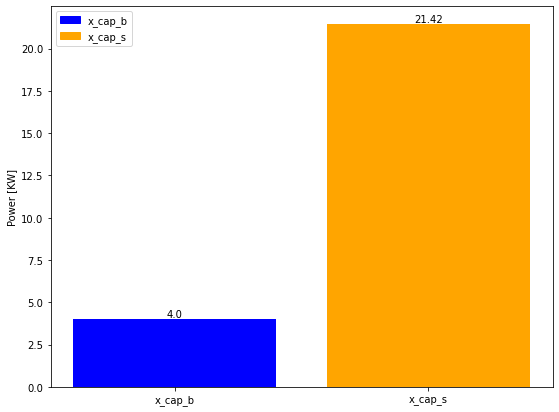

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming x_cap_b.x and x_cap_s.x are your values, and color_x_cap_b, color_x_cap_s are your colors
color_x_cap_b = 'blue'
color_x_cap_s = 'orange'
values = [x_cap_b.x, x_cap_s.x]
labels = ['x_cap_b', 'x_cap_s']
colors = [color_x_cap_b, color_x_cap_s]

fig, axs_first_stage = plt.subplots(figsize=(9, 7))
axs_first_stage.set_ylabel('Power [KW]')
#axs_first_stage.set_title('First Stage Variables')
bars = axs_first_stage.bar(labels, values, color=colors)

# Adding annotations to each bar
for bar, value in zip(bars, values):
    axs_first_stage.text(bar.get_x() + bar.get_width() / 2, 
                         bar.get_height(), 
                         round(value, 2), 
                         ha='center', 
                         va='bottom')

# Creating custom legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, colors)]
axs_first_stage.legend(handles=legend_patches)

# Save the figure as PDF
plt.savefig('size.pdf')


plt.show()

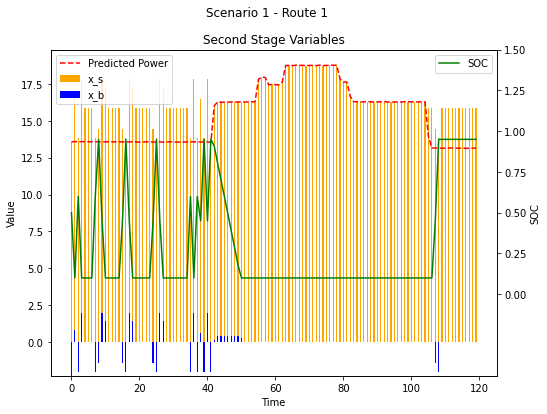

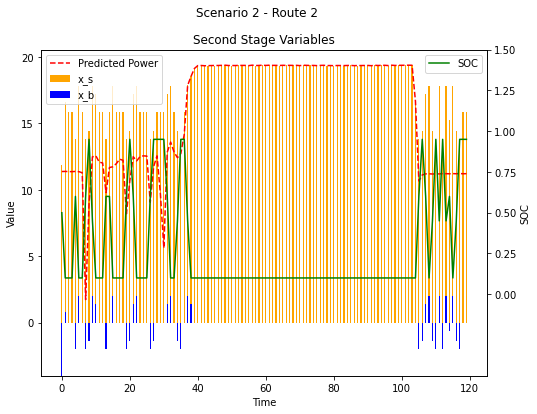

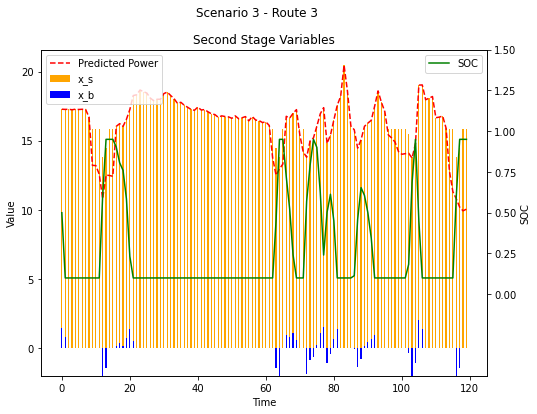

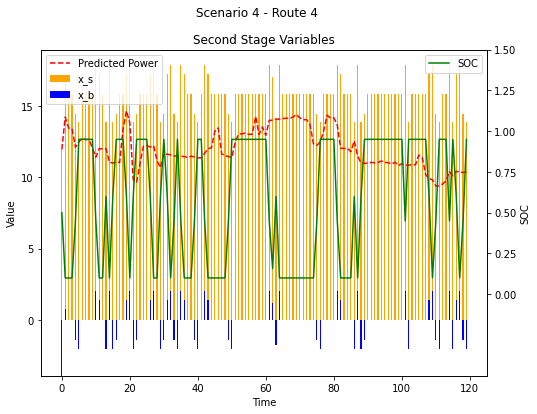

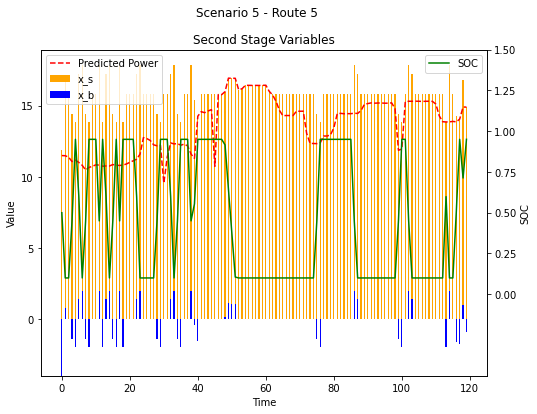

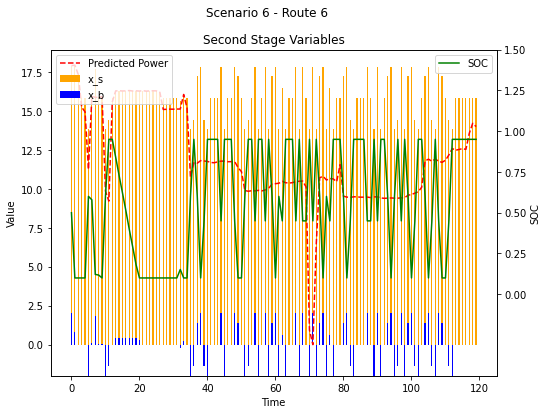

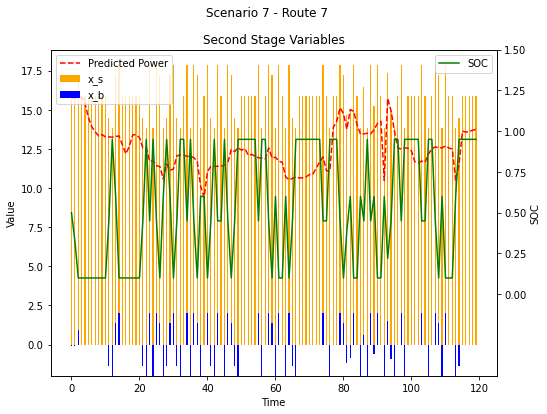

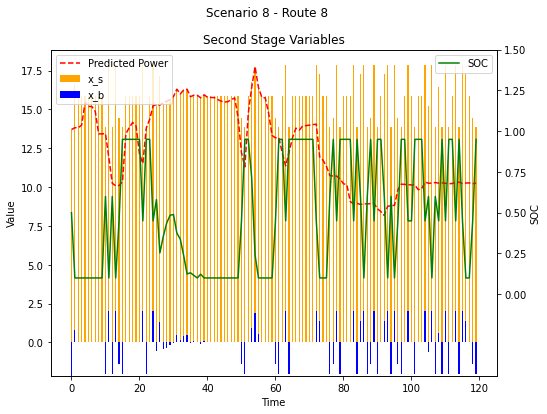

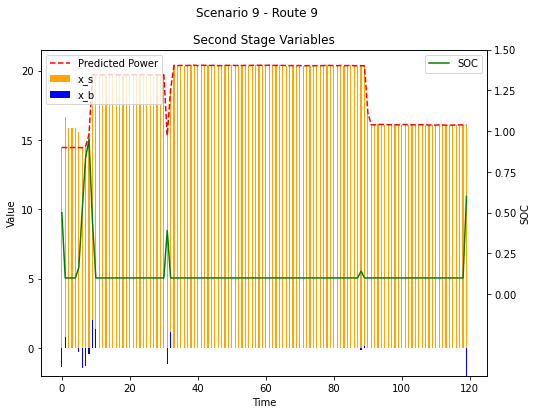

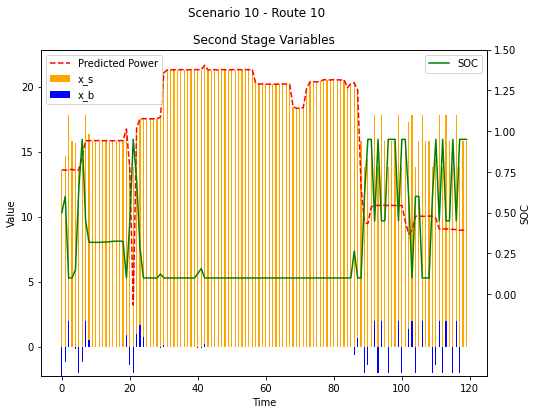

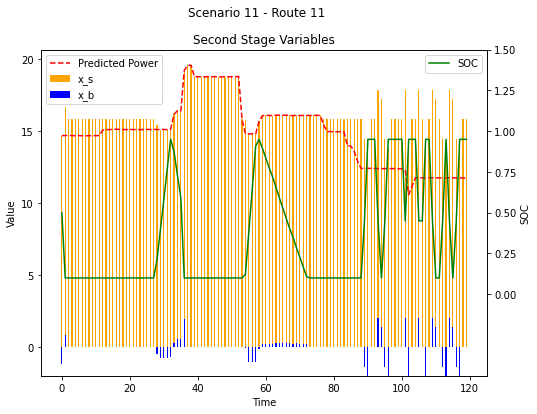

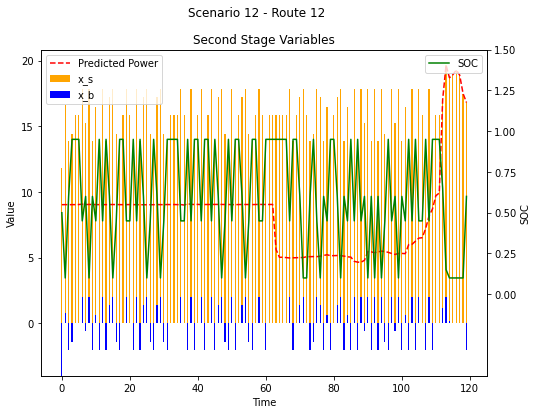

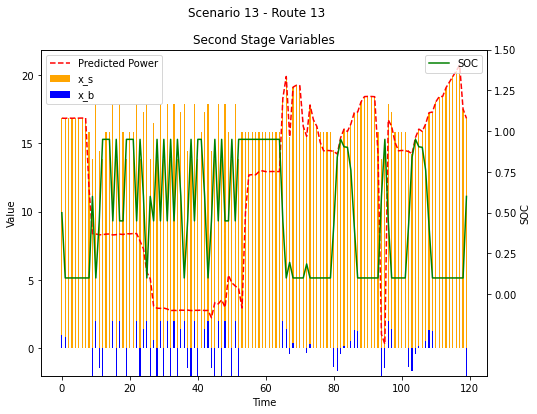

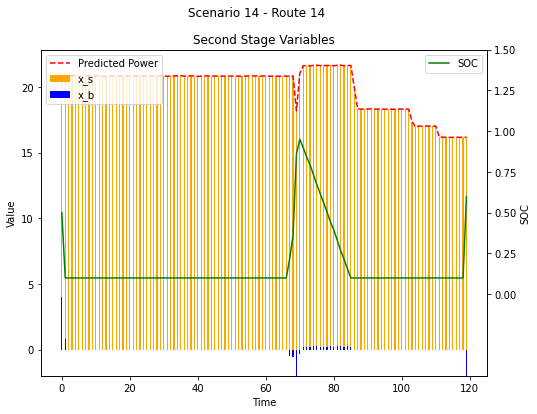

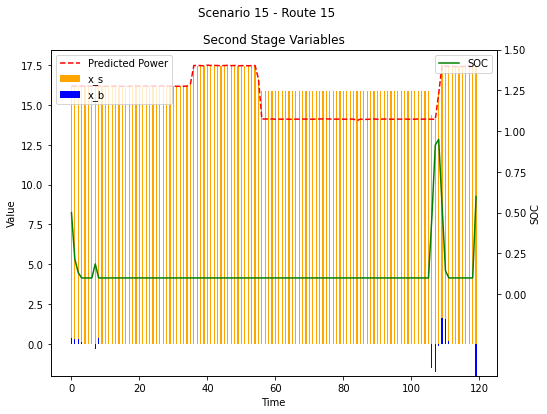

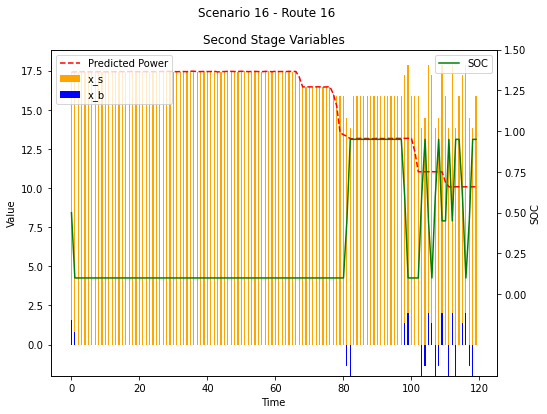

In [8]:
# Define colors for consistency
color_x_cap_b = 'blue'
color_x_cap_s = 'orange'
color_x_b = 'blue'
color_x_s = 'orange'
color_load = 'red'  # Color for the load curve

# Define routes for each scenario (adjust as needed)
routes = [f'Route {i + 1}' for i in range(len(S))]  # Example: ['Route 1', 'Route 2', ...]

# Plotting the scenarios
for s in S:
    fig, axs_second_stage = plt.subplots(figsize=(8, 6))
    fig.suptitle(f"Scenario {s + 1} - {routes[s]}")  # Displaying corresponding route

    # Second Stage Variables Plot (Bar Plot)
    x_s_values = [x_s[t, s].x for t in T]
    x_b_values = [x_b[t, s].x for t in T]
    soc_values = [soc[t, s].x for t in T[1:]]  # Assuming `soc` is defined
    soc_values = [0.5] + soc_values  # Assuming an initial SOC value

    # Fetch Predicted Power values from table_power for the specific route
    load_column_name = f'Predicted Power for {routes[s]}'  # Using the correct route
    if load_column_name in table_power.columns:
        load_values = table_power[load_column_name].values[:len(T)]
    else:
        print(f"Warning: Column '{load_column_name}' not found in table_power.")
        load_values = [0] * len(T)  # Default to zero if column not found

    bar_width = 0.35
    index = np.arange(len(T))

    ax1 = axs_second_stage
    ax2 = ax1.twinx()  # Create a twin Axes sharing the same x-axis
    ax1.bar(index, x_s_values, bar_width, bottom=x_b_values, color=color_x_s, label='x_s')
    ax1.bar(index, x_b_values, bar_width, color=color_x_b, label='x_b')

    # Plot SOC on the right axis
    ax2.plot(index, soc_values, color='green', label='SOC')  

    # Plot load (Predicted Power) on the same axis as x_s and x_b
    ax1.plot(index, load_values, color=color_load, label='Predicted Power', linestyle='--')

    # Labels and legends
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.set_title('Second Stage Variables')
    ax1.legend(loc='upper left')

    ax2.set_ylabel('SOC')
    #ax2.set_ylim(-1.2, max(soc_values) + 0.6) 
    ax2.set_ylim(-0.5, 1.5)
    ax2.legend(loc='upper right')
    
    # Control y-ticks for ax2 to avoid negative values
    ax2.set_yticks([tick for tick in ax2.get_yticks() if tick >= 0])

# Show the plots
plt.show()


In [9]:
for s in S:
    total_sum = sum((x_b[t, s].x + x_s[t, s].x - table_power[f'Predicted Power for Route {s + 1}'].values[t]) 
                    for t in T)
    print(f's = {s + 1}, total sum = {total_sum}')


s = 1, total sum = 127.36240602631115
s = 2, total sum = 228.91292358732747
s = 3, total sum = 65.42852592237558
s = 4, total sum = 455.289067739863
s = 5, total sum = 266.9183384463794
s = 6, total sum = 474.45708395757254
s = 7, total sum = 395.4297194962336
s = 8, total sum = 386.22922710962854
s = 9, total sum = 7.52266681536811
s = 10, total sum = 209.29403075177473
s = 11, total sum = 162.11568755513122
s = 12, total sum = 923.0866308648923
s = 13, total sum = 562.4536771994035
s = 14, total sum = 0.0
s = 15, total sum = 87.25979813664425
s = 16, total sum = 154.9888921369299


In [10]:
for s in S:
    total_sum = sum(x_s[t, s].x for t in T)
    print(f's = {s + 1}, total sum = {total_sum}')

s = 1, total sum = 1980.4607305274112
s = 2, total sum = 2132.8007480081196
s = 3, total sum = 2002.159427316967
s = 4, total sum = 1901.9991923064629
s = 5, total sum = 1906.8074793394335
s = 6, total sum = 1907.4043084044501
s = 7, total sum = 1901.9991923064629
s = 8, total sum = 1901.9991923064629
s = 9, total sum = 2253.3884426917834
s = 10, total sum = 2188.3786840036523
s = 11, total sum = 1952.775669961548
s = 12, total sum = 1920.6554690285004
s = 13, total sum = 1968.8700416267332
s = 14, total sum = 2394.6004416606156
s = 15, total sum = 1960.534266442154
s = 16, total sum = 2013.1070599693485


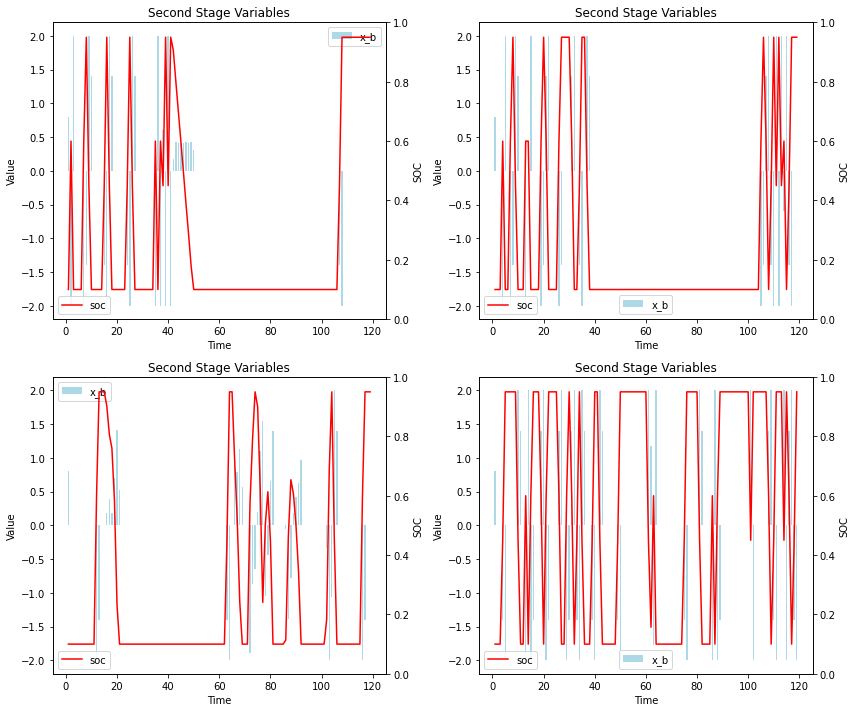

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have defined S, T, x_b, and soc somewhere in your code

# Define colors
color_x_b = 'lightblue'

# Plotting the scenarios
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for s, ax in zip(S, axs.flat):
    ax.set_title(f"Scenario {s + 1}")

    # Second Stage Variables Plot (Bar Plot)
    x_b_values = [x_b[t, s].x for t in T[1:]]  # Exclude t=0
    soc_values = [soc[t, s].x for t in T[1:]]  # Exclude t=0
    
    bar_width = 0.55
    index = np.arange(1, len(T))  # Exclude t=0
    
    ax1 = ax
    ax2 = ax.twinx()  # Create a twin Axes sharing the same x-axis
    ax1.bar(index, x_b_values, bar_width, color=color_x_b, label='x_b')
    ax2.plot(index, soc_values, color='red', label='soc')  # Plot soc on the right axis
    
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.set_title('Second Stage Variables')
    #ax1.legend(loc='upper left')
    ax2.set_ylabel('SOC')
    #ax2.legend(loc='upper right')
    
    # Control the y-axis limits of ax2
    ax2.set_ylim(-1.2, max(soc_values) + 0.6 ) 
    ax2.set_ylim(0, 1) 
    #ax2.legend(loc='upper right')
    ax2.legend()
    ax1.legend()
    
    ax2.set_yticks([tick for tick in ax2.get_yticks() if tick >= 0])

plt.tight_layout()
plt.show()

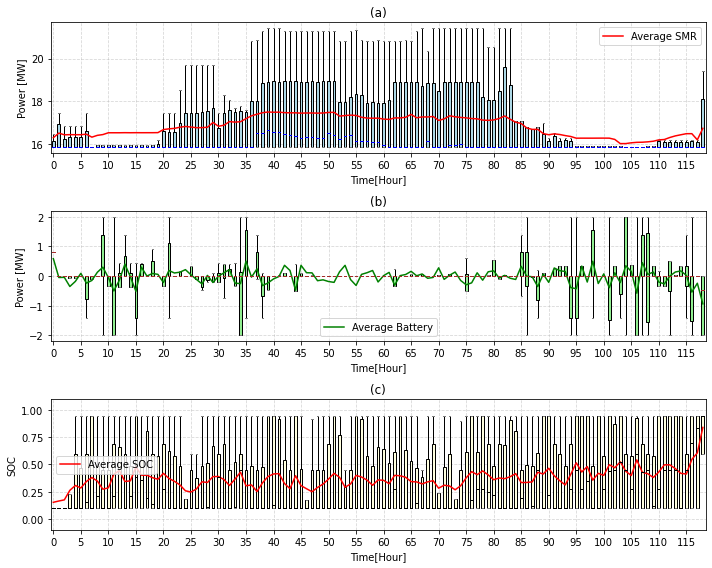

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize arrays to store data for boxplots
boxplot_data_x_s = []
boxplot_data_x_b = []

# Iterate over time starting from t=1
for t in range(1, len(T)):  
    # Calculate data for boxplots
    x_s_values = [x_s[t, s].x for s in S]
    x_b_values = [x_b[t, s].x for s in S]
    boxplot_data_x_s.append(x_s_values)
    boxplot_data_x_b.append(x_b_values)

# Calculate averages for x_s and x_b
avg_x_s = np.mean(boxplot_data_x_s, axis=1)
avg_x_b = np.mean(boxplot_data_x_b, axis=1)

# Initialize an empty list to store SOC data for each time point
soc_data = []

# Iterate over time (starting from the second time point)
for t in T[1:]:
    # Calculate SOC values for each scenario at time t
    soc_values = [soc[t, s].x for s in S]
    soc_data.append(soc_values)

# Convert soc_data to a numpy array
soc_data = np.array(soc_data)

# Calculate average SOC values for each time point
average_soc = np.mean(soc_data, axis=1)

# Create 3x1 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

# Plot the boxplots for x_s on ax1 without showing outliers
boxplot_s = ax1.boxplot(boxplot_data_x_s, positions=np.arange(1, len(boxplot_data_x_s) + 1), labels=x_labels[1:], 
                         patch_artist=True, boxprops=dict(facecolor='lightblue'), 
                         whiskerprops=dict(color='black'), capprops=dict(color='gray'), 
                         medianprops=dict(color='blue'), showfliers=False)

# Plot the boxplots for x_b on ax2 without showing outliers
boxplot_b = ax2.boxplot(boxplot_data_x_b, positions=np.arange(1, len(boxplot_data_x_b) + 1), labels=x_labels[1:], 
                         patch_artist=True, boxprops=dict(facecolor='lightgreen'), 
                         whiskerprops=dict(color='black'), capprops=dict(color='gray'), 
                         medianprops=dict(color='brown'), showfliers=False)

# Plot the average curve for x_s on ax1
ax1.plot(np.arange(1, len(avg_x_s) + 1), avg_x_s, color='red', label='Average SMR')

# Plot the average curve for x_b on ax2
ax2.plot(np.arange(1, len(avg_x_b) + 1), avg_x_b, color='green', label='Average Battery')

# Set titles for both subplots
ax1.set_title('(a)')
ax2.set_title('(b)')

# Add grid lines for both subplots
ax1.grid(True, linestyle='--', alpha=0.5)
ax2.grid(True, linestyle='--', alpha=0.5)

# Set x-axis label for both subplots
ax2.set_xlabel('Time[Hour]')
ax1.set_xlabel('Time[Hour]')

# Set y-axis label for both subplots
ax1.set_ylabel('Power [MW]')
ax2.set_ylabel('Power [MW]')

# Add legends for both subplots
ax1.legend()
ax2.legend()

# Set x-ticks and labels
tick_positions = np.arange(len(x_labels)) + 1
ax1.set_xticks(tick_positions[::5])  # Show only alternate ticks
ax1.set_xticklabels(x_labels[::5])  # Show only alternate labels
ax2.set_xticks(tick_positions[::5])  # Show only alternate ticks
ax2.set_xticklabels(x_labels[::5])  # Show only alternate labels

# Plot SOC boxplot on ax3
boxplot_soc = ax3.boxplot(soc_data.T, labels=T[1:], patch_artist=True, boxprops=dict(facecolor='lightyellow'), 
                          whiskerprops=dict(color='black'), capprops=dict(color='gray'), 
                          medianprops=dict(color='black'), showfliers=False)

# Plot the average SOC curve on ax3
ax3.plot(np.arange(1, len(average_soc) + 1), average_soc, color='red', label='Average SOC')

# Set x-axis and y-axis labels for ax3
ax3.set_xlabel('Time[Hour]')
ax3.set_ylabel('SOC')
ax3.set_ylim(-0.1, 1.1)

# Set title for ax3
ax3.set_title('(c)')

# Add grid and legend to ax3
ax3.grid(True, linestyle='--', alpha=0.5)
ax3.legend()

# Set x-ticks and labels for ax3
ax3.set_xticks(tick_positions[::5])
ax3.set_xticklabels(x_labels[::5])

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the combined figure as a PDF
plt.savefig('combined_boxplot_SOC.pdf')
plt.show()
